# Summary of Results

In [1]:
import pandas as pd
import tools as ds
from IPython.display import Image

## Data Sample

In [2]:
crashes_initial = pd.read_csv('data/Crashes.csv')
crashes_initial.head()

CASE_ID  ACCIDENT_YEAR   PROC_DATE  JURIS COLLISION_DATE  COLLISION_TIME  \
0  7034739           2015  2015-08-22   3801     2015-02-26            1931   
1  7035304           2014  2015-08-24   3801     2014-12-25            2245   
2  7202472           2016  2016-03-09   3801     2016-02-11            1100   
3  8042422           2016  2016-05-16   3801     2016-04-13            1050   
4  8046723           2016  2016-05-18   3801     2016-04-16            1614   

  OFFICER_ID REPORTING_DISTRICT  DAY_OF_WEEK  CHP_SHIFT  ...  COUNT_MC_KILLED  \
0     000985              RICHM            4          5  ...                0   
1     A09861              INGLE            4          5  ...                0   
2       1572                NaN            4          5  ...                0   
3     001588              CENTR            3          5  ...                0   
4       2472              MISIS            6          5  ...                0   

   COUNT_MC_INJURED  PRIMARY_RAMP  SECONDARY_RAMP LATITUDE  LONGITUDE  \
0                 0            -               -       NaN        NaN   
1                 0            -               -       NaN        NaN   
2                 0            -               -       NaN        NaN   
3                 0            -               -       NaN        NaN   
4                 0            -               -       NaN        NaN   

          COUNTY           CITY     POINT_X    POINT_Y  
0  SAN FRANCISCO  SAN FRANCISCO -122.458750  37.779350  
1  SAN FRANCISCO  SAN FRANCISCO -122.418788  37.710855  
2  SAN FRANCISCO  SAN FRANCISCO -122.395850  37.781310  
3  SAN FRANCISCO  SAN FRANCISCO -122.399682  37.794241  
4  SAN FRANCISCO  SAN FRANCISCO -122.429839  37.761200  

[5 rows x 80 columns]

### Data Preprocessing

There are 80 columns describing a bike crash instance, with many containing code words that are interpreted here: https://tims.berkeley.edu/help/SWITRS.php#Codebook which was retrieved from [@tims]. SWITRS (which TIMS is based on) can be found here [@switrs]. We decode them with the help of `pandas` [@pandas] and `numpy` [@numpy]

## EDA : Visualizing Bike Collision Trends

In our analysis, we aim to identify general trends across bike collisions, spanning temporal and categorical conditions. In these visuals we explore the impact of the pandemic, time of year, time of day, and several road and accident conditions that are associated with our data's bike crashes.

The onset of the pandemic is associated with a significant drop in bike collisions, very likely due to the fact that there was a general drop in people riding bikes in places or times that were higher risk of getting into a collision. We speculate that a number of factors contributed to the decrease in high-risk bike use from the pandemic, such as the initial quarantine, the residual hybrid or remote work, and general changes in transportation habits. Despite the pandemic conditions improving by 2023, we still a slow inertia in returning to pre-pandemic biking conditions, as seen below:

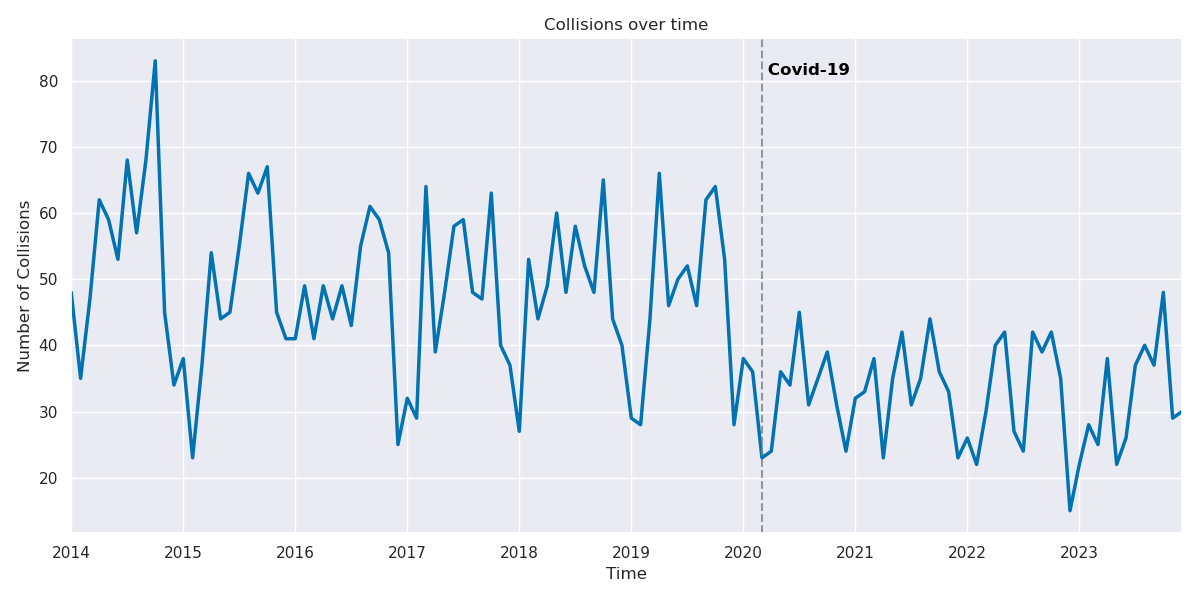

In [5]:
Image(filename = "figures/Collisions_by_year.png")

Looking at collisions by month, we see a general trend of less commuters during the winter months of December, January, and February. Brr!

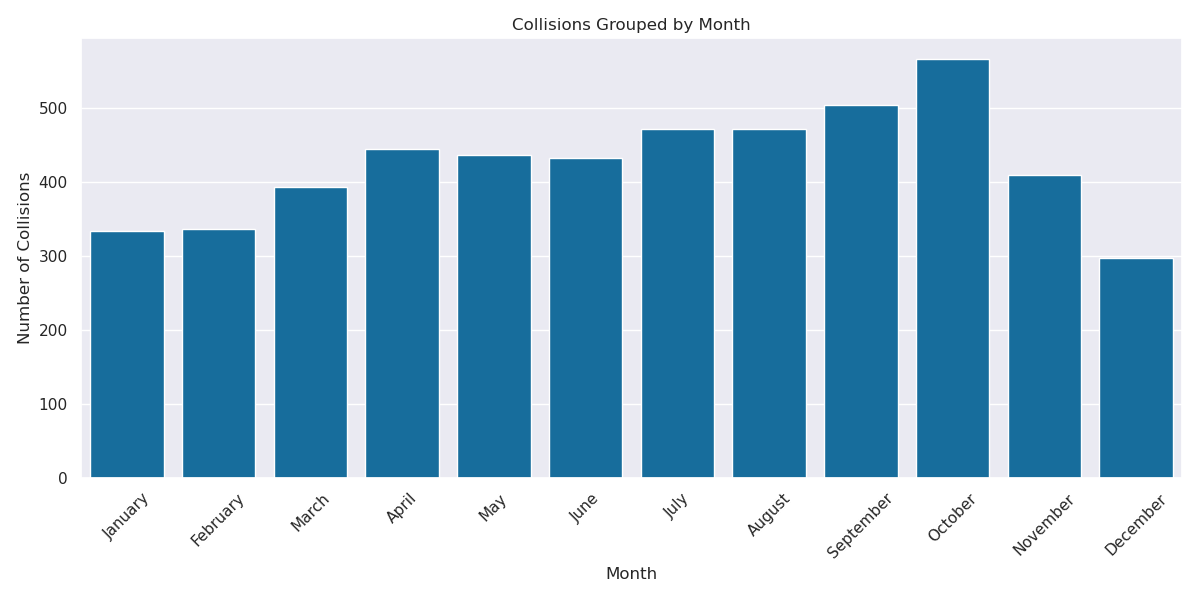

In [6]:
Image(filename = "figures/Collisions_by_month.png")

As shown in the figure below, there are no very obvious differences across seasons, in terms of categorical condition variation. However, there is certainly a marked differences in the number of crashes per season, with Winter having the lowest and Fall having the highest (cumulatively). We also note that Fall and Winter have more crashes in the dark, likely due to shorter days but unchanging work hours.

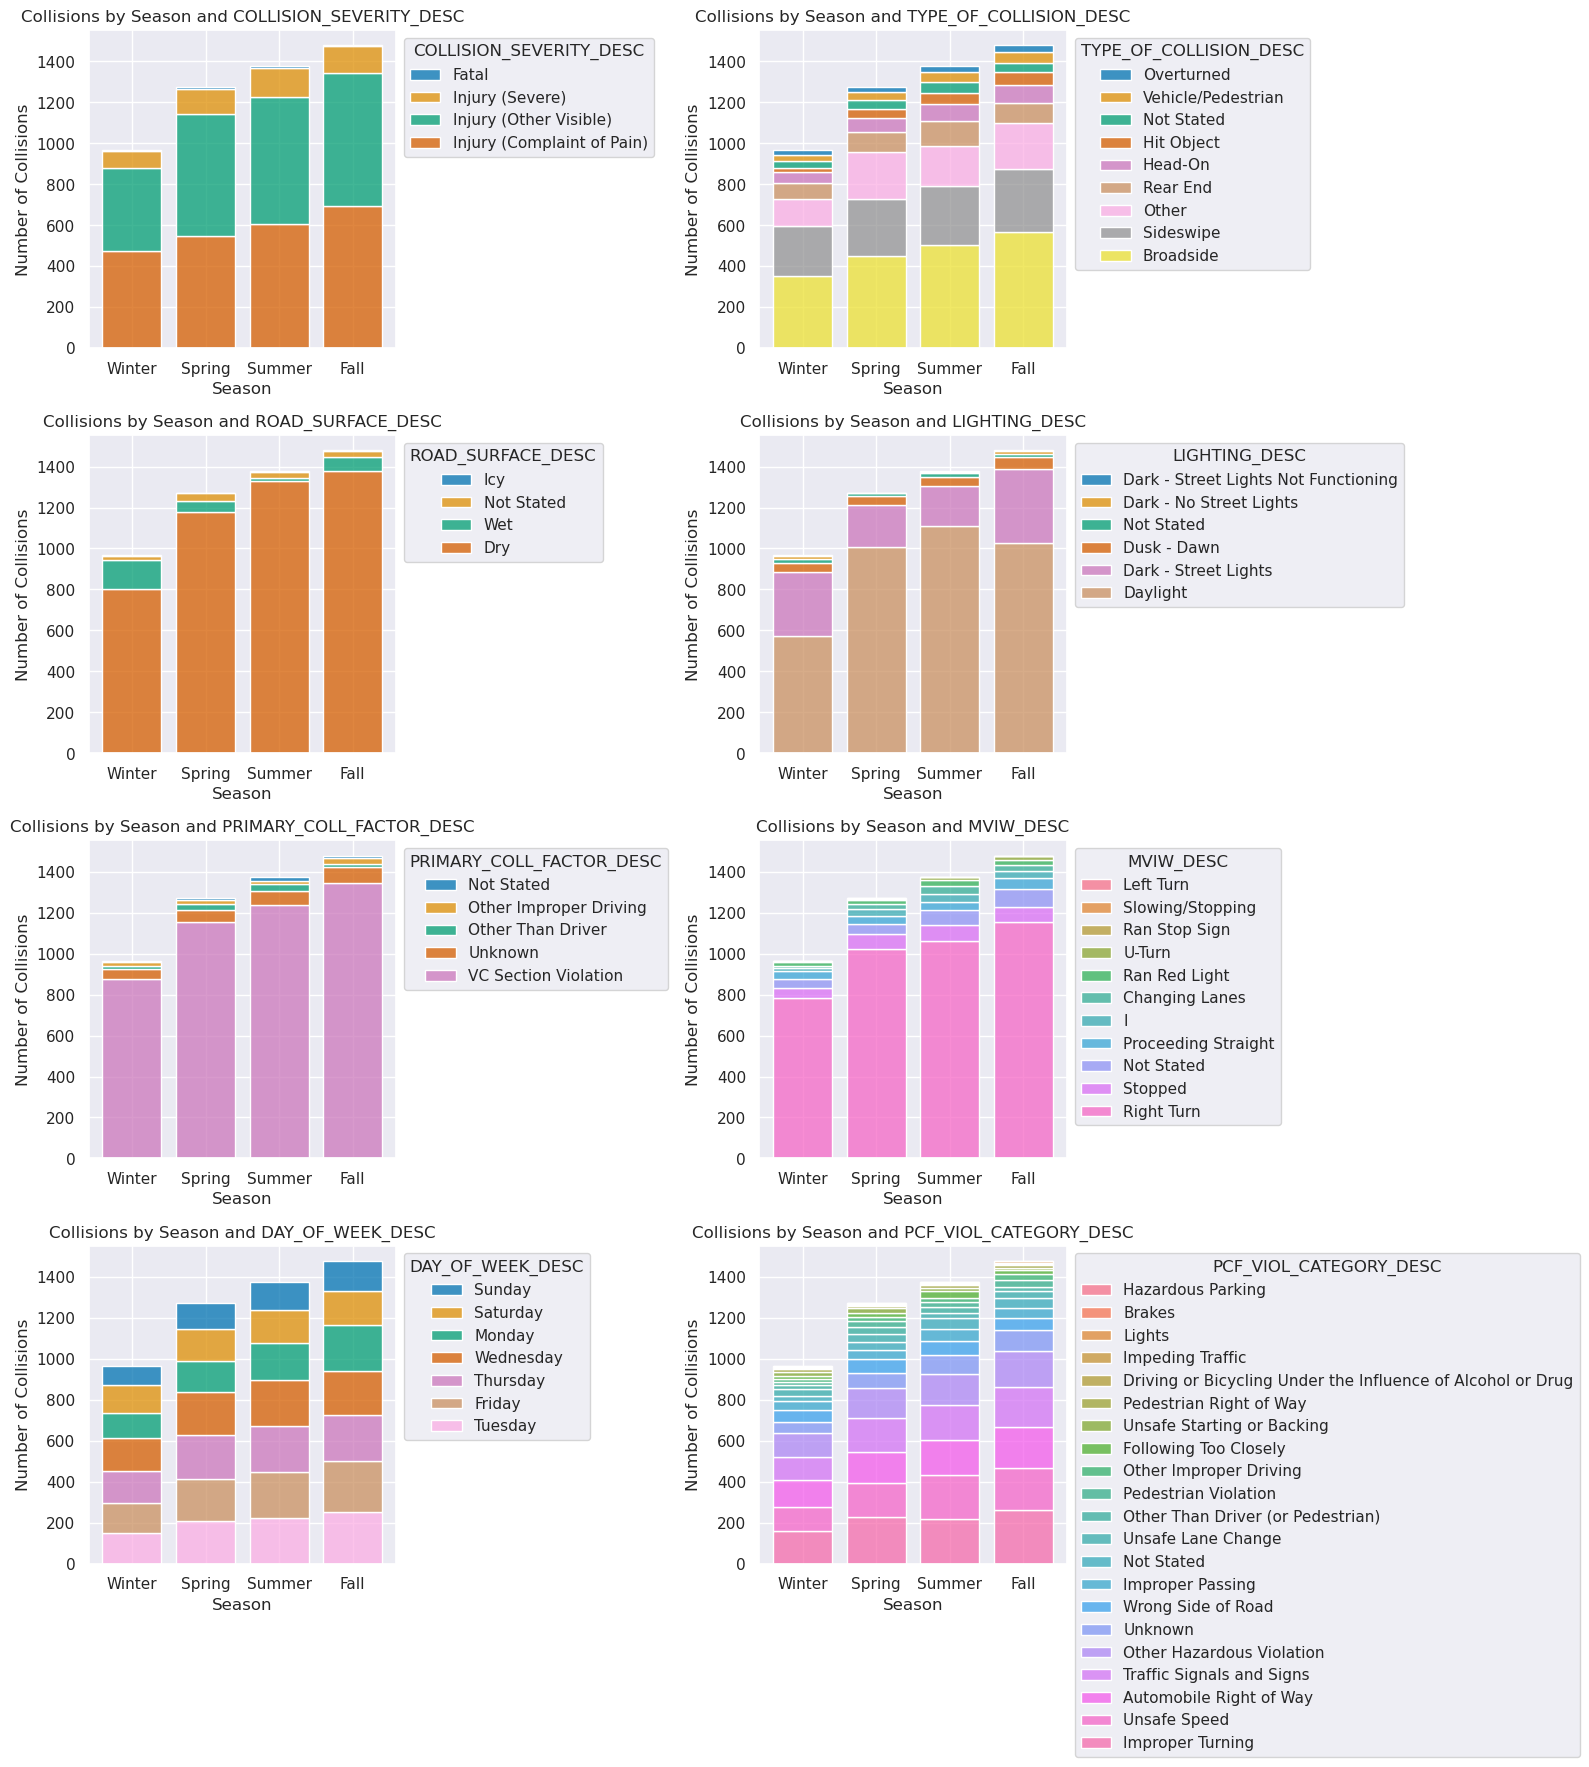

In [7]:
Image(filename = "figures/Collisions_Categories_by_Season.png")

We conducted the same categorical tests, but across days of the week. We see a noteable difference between the typical Monday - Friday work week with lower collision counts for the typical Saturday and Sunday weekend. 'Recreational' biking, we infer, is less of a contributor to SF's bike collisions as compared to commuting bike accidents, where bikers are commuting in the morning alongside cars and busses.  

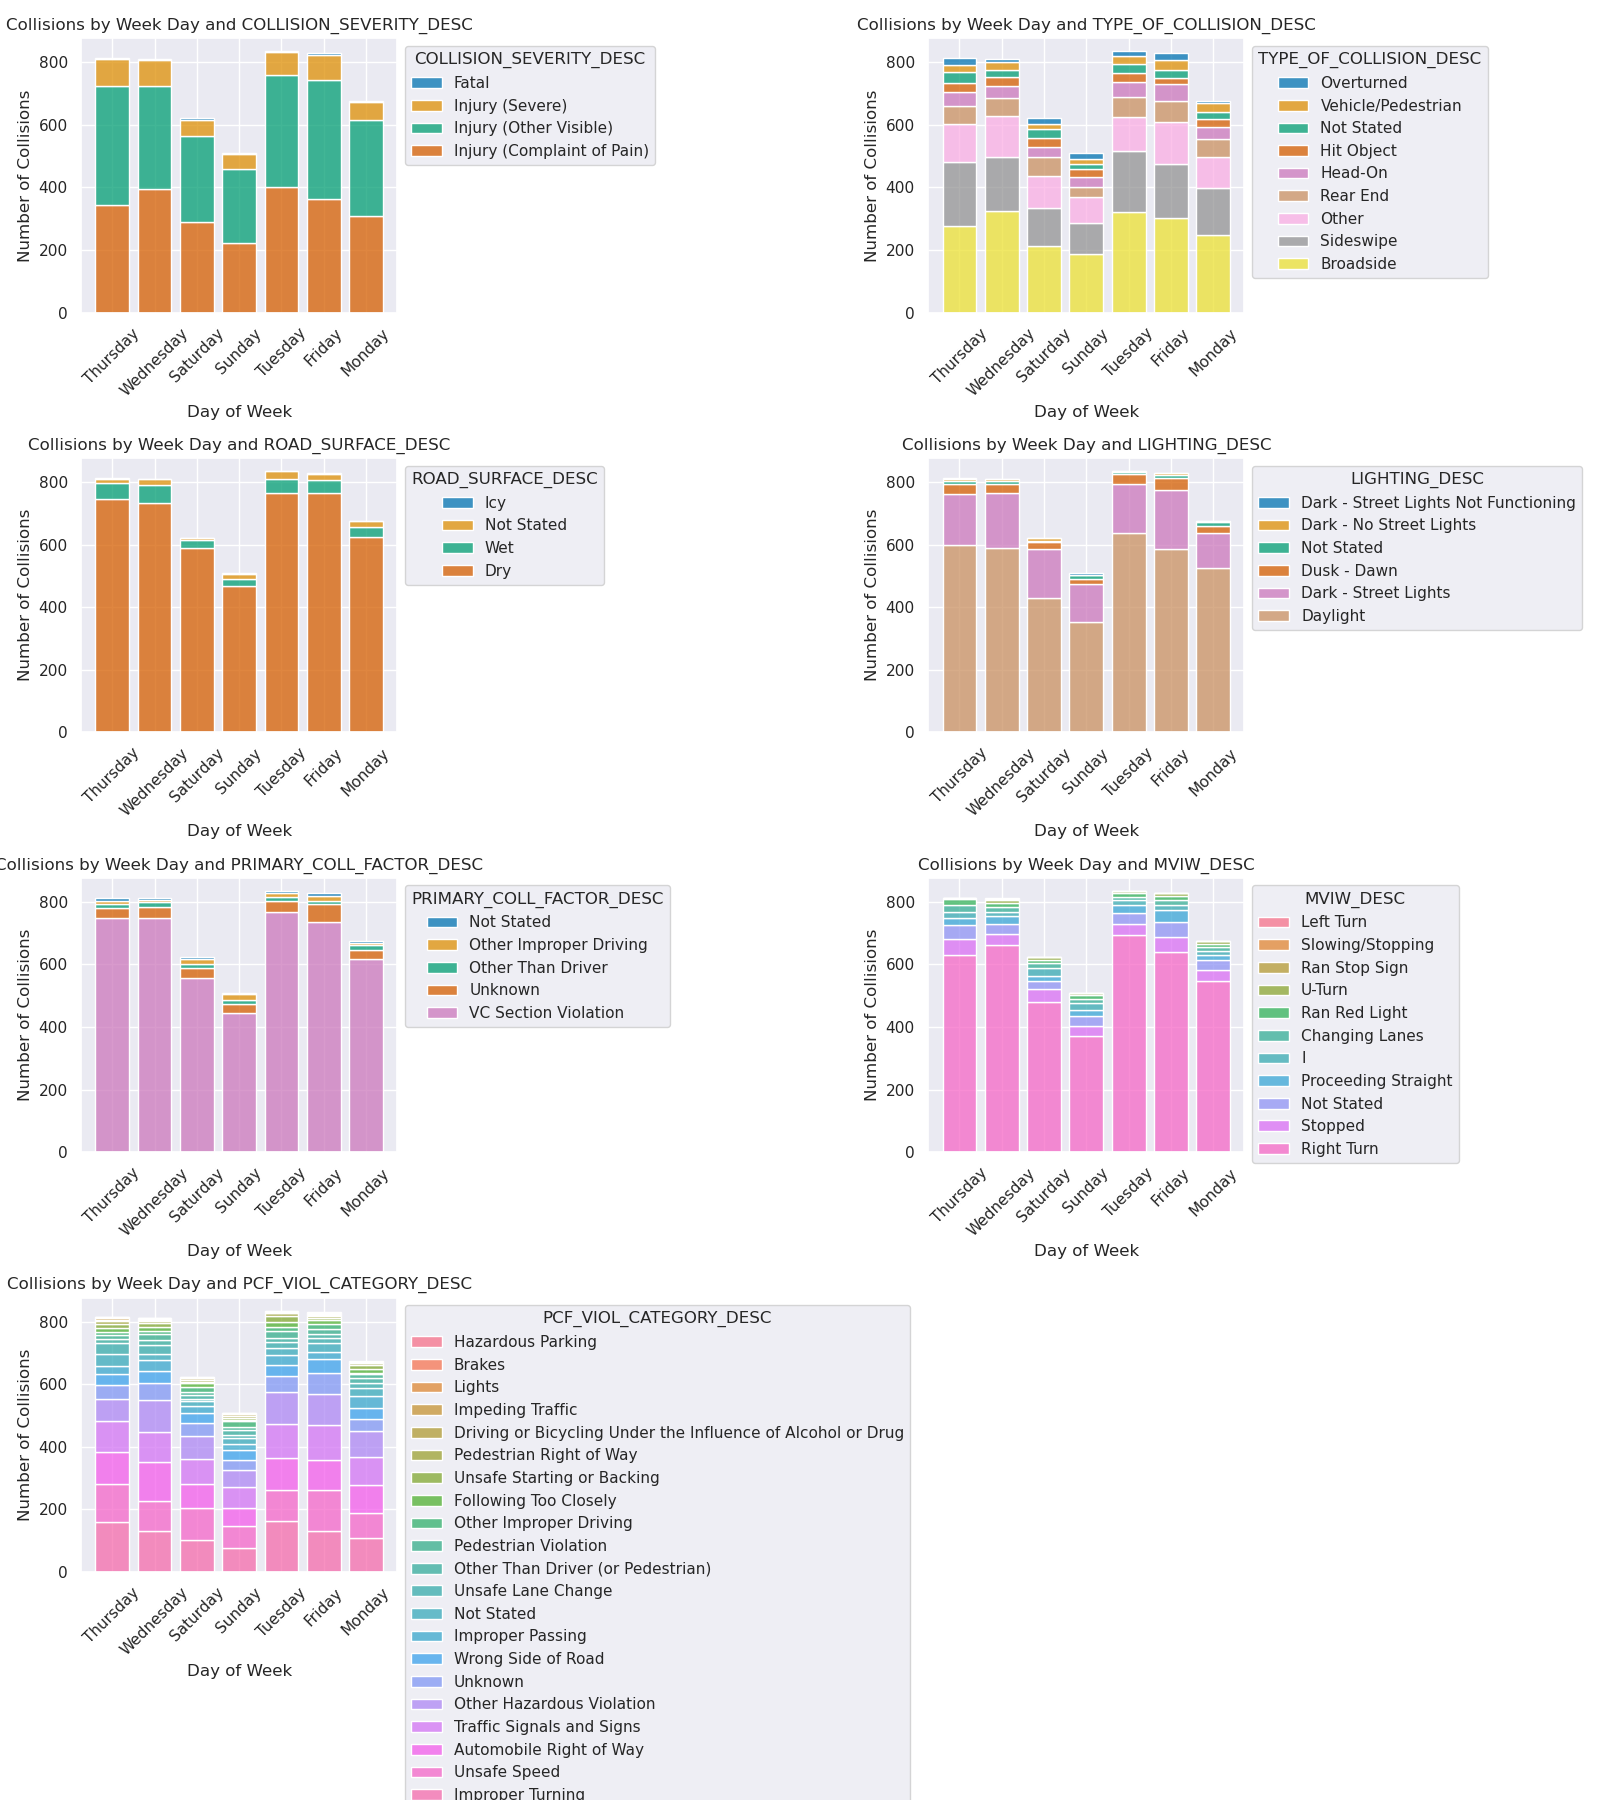

In [8]:
Image(filename = "figures/Collisions_Conditions_by_Day.png")

Next we explore the time of day and how that correlates with bike crashes. In the graphs below we observe that weekday crashes are markedly near morning and evening commute time of the 9-5 workday, while weekends follow a more normal distribution. The overwhelming majority of weekday crashes mean that the cumulative collision by time of day graph follows most closely with the weekday trends.

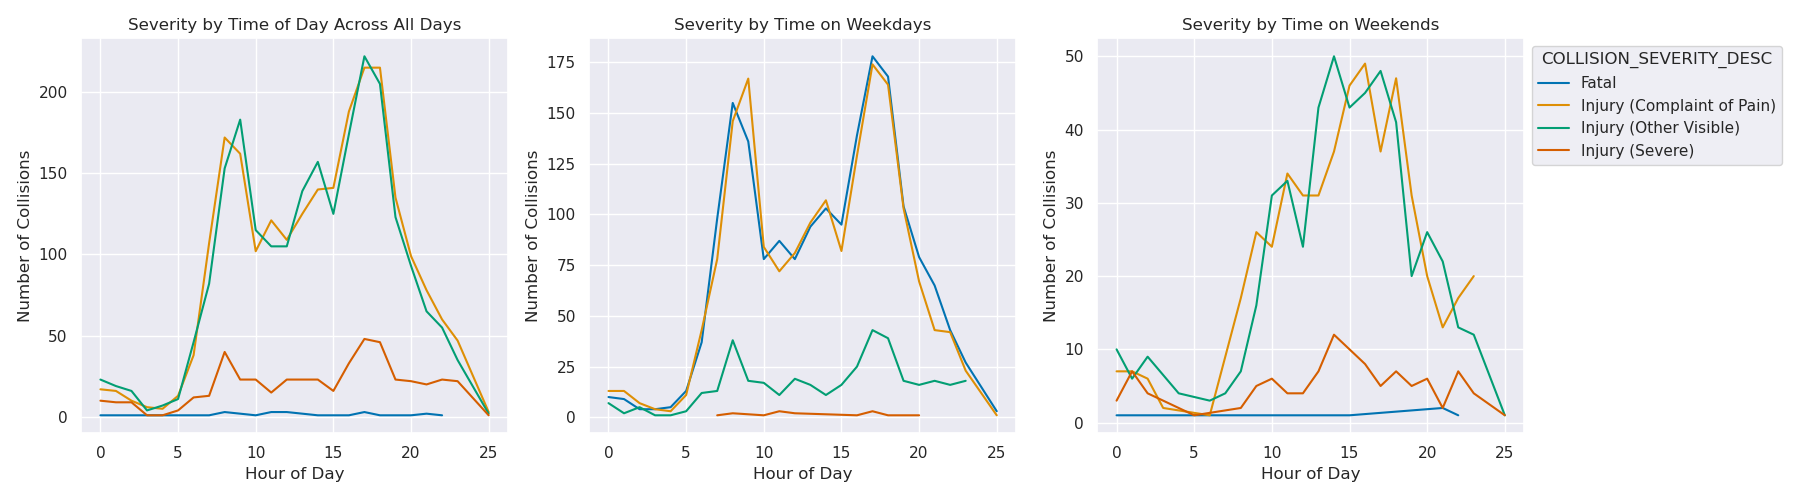

In [9]:
Image(filename = "figures/Collisions_by_TOD.png")

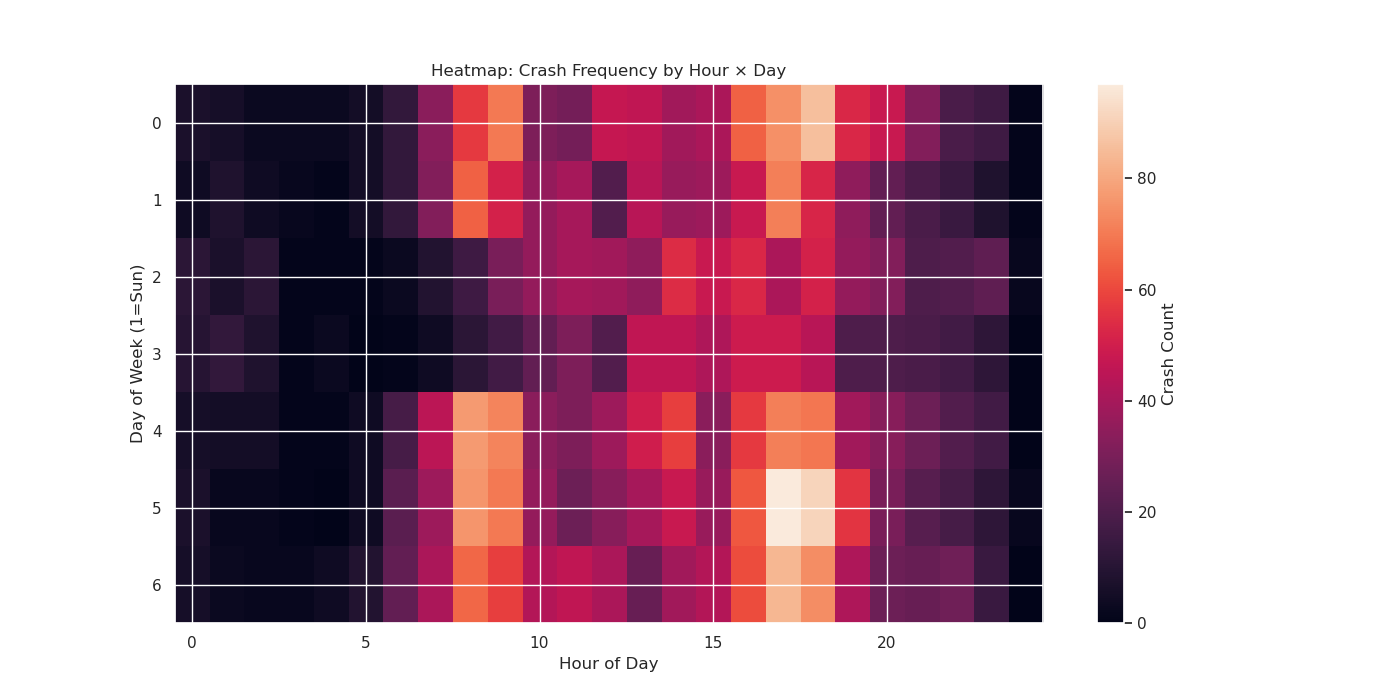

In [10]:
Image(filename = "figures/Crash_Heatmap.png")

#### Severe Crashes

The focal point of our research question is to understand the conditions that are present in the case of severe or fatal crashes. In the data visualizations below, we find a number of insights. Thankfully, the share of fatalities and severe injuries from bike crashes are extremely low compared to minor injuries. When looking at severity proportions by collision factors, a few things come to light. BUI's (Biking Under the Influence), biking on the wrong side of road, brake malfunctions, conditions other outside of the biker's control seem to have higher proportions of crash severity.

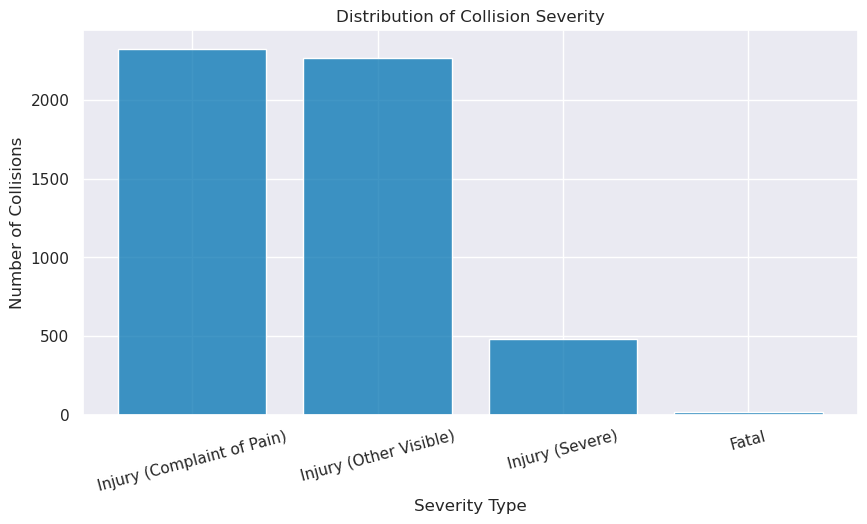

In [11]:
Image(filename = "figures/Distr_Collision_Severity.png")

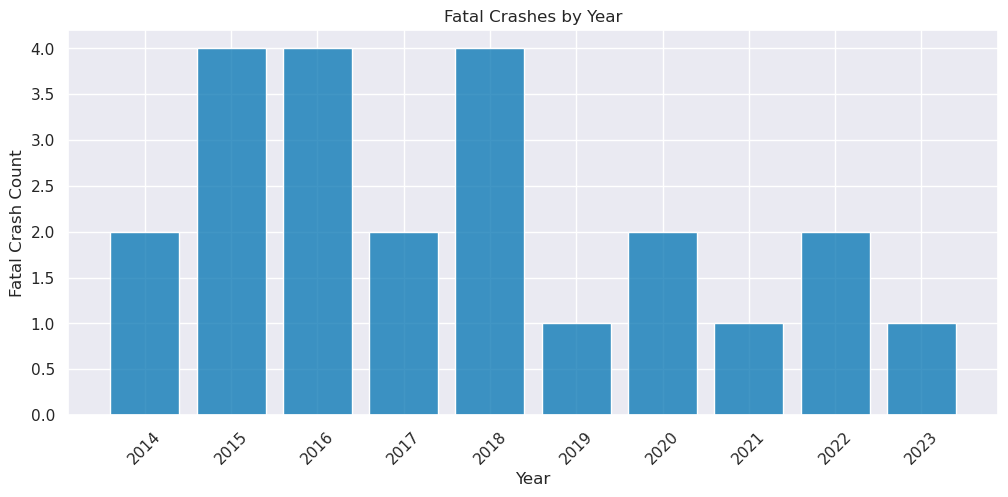

In [12]:
Image(filename = "figures/Fatalities_by_year.png")

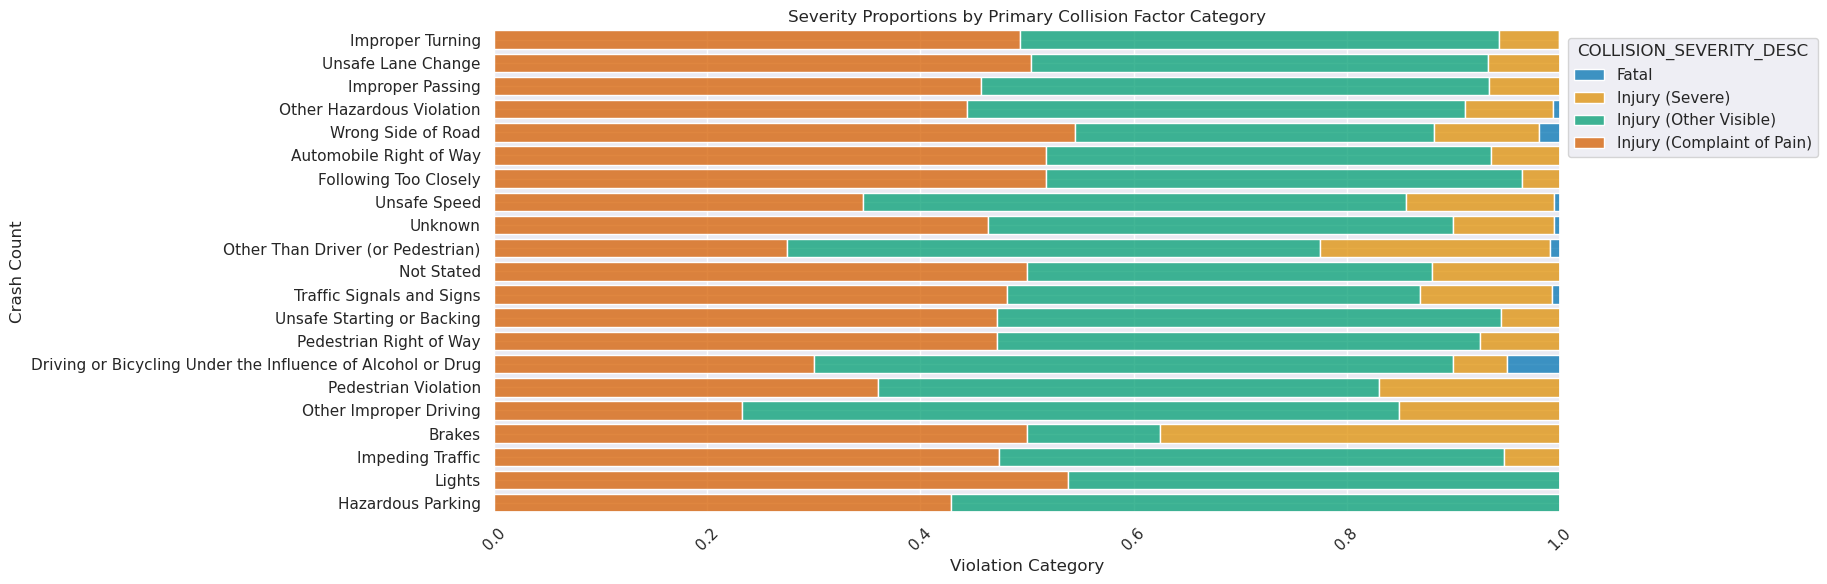

In [13]:
Image(filename = "figures/Collis_Factor_Proportions.png")

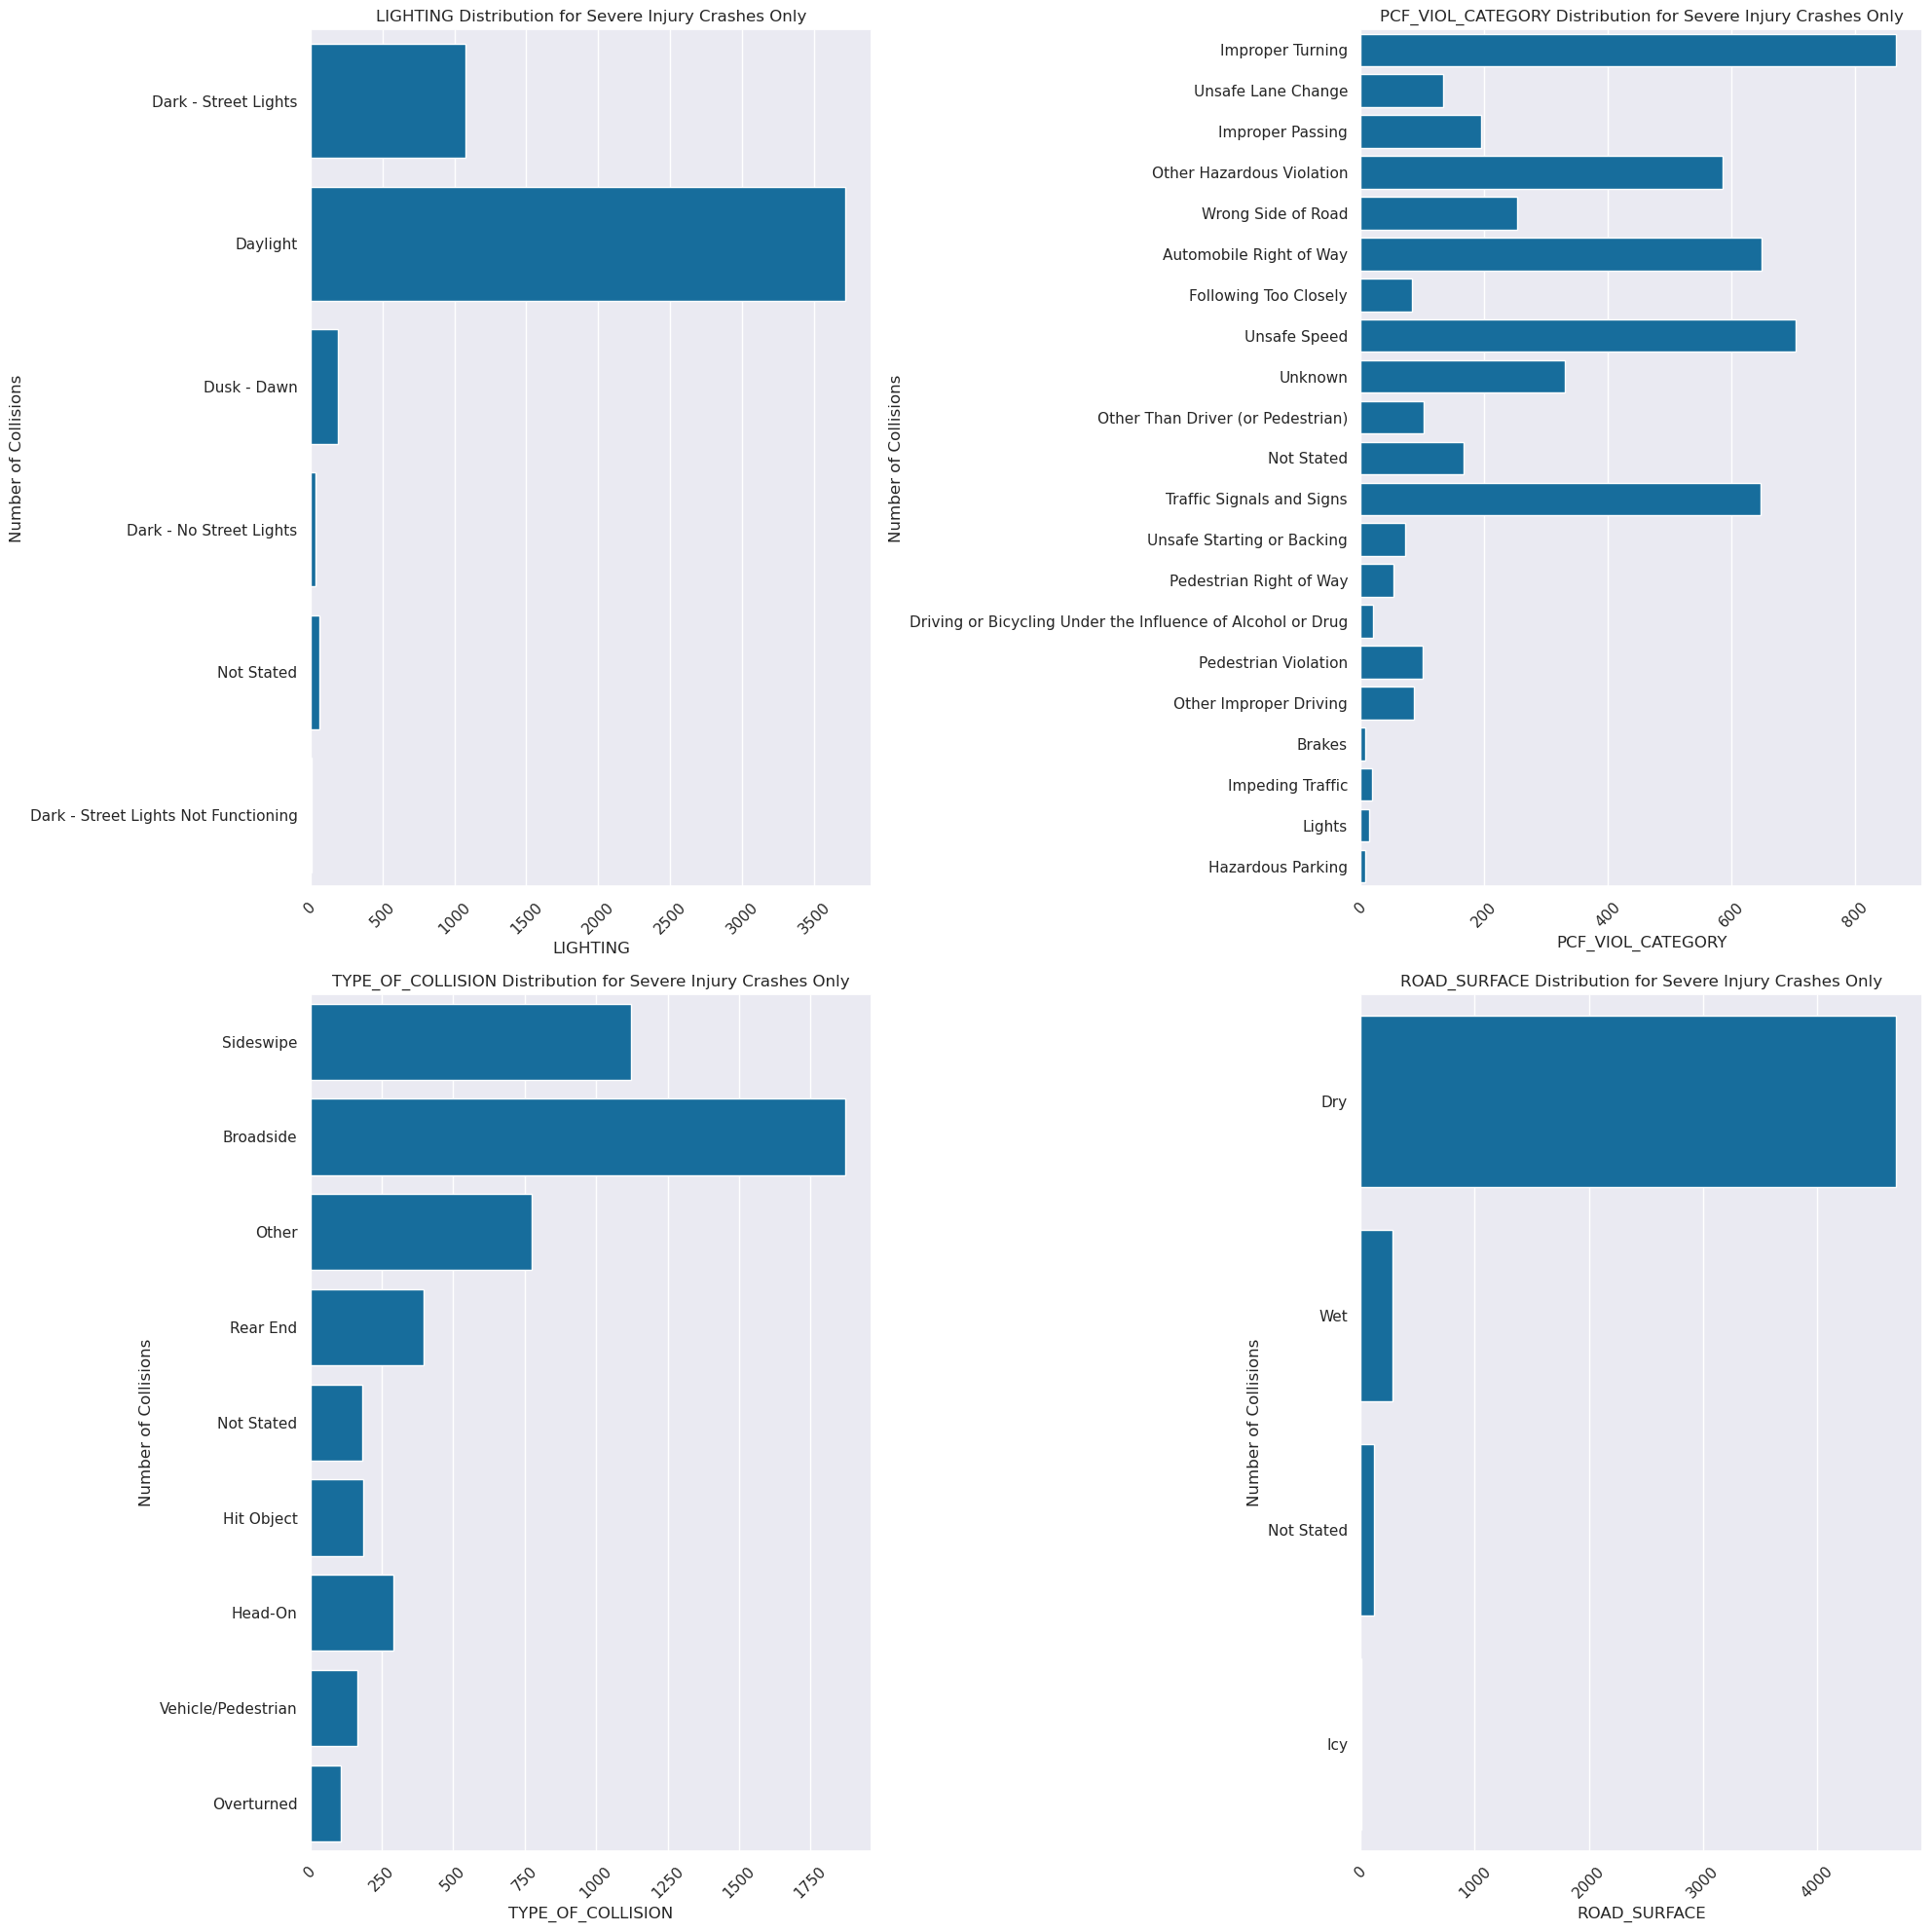

In [14]:
Image(filename = "figures/Severe_Conditions.png")

# Where do Severe Crashes Happen Often?

This section will use the Kernel Density Estimation (KDE) [@silverman1986density] and DBSCAN Clustering methods [@ester1996dbscan] to identify locations in San Francisco (SF) that see the highest amount of bike crashes. The KDE method combined with GeoPandas [@geopandas] will help visualize crash hotspots around SF. This analysis will continue with all severity of crashes to see if there are locations with greater severities than others.

It is important to note that it may be expected that more crashes will occur in locations where there is more bike/vehicle traffic. However, the infrastructure of the road should match the volume. Therefore, if a high-volume street is showing multiple crashes, that indicates that existing infrasturcture does not support the expected interactions, and infrastructure change would still be needed to address the higher crash occurances.

In [15]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import contextily as ctx
from math import radians
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from shapely.geometry import Point

In [16]:
crashes = pd.read_csv("data/Crashes.csv")
crashes = crashes.dropna(subset=['POINT_X', 'POINT_Y'])

In [17]:
#Cleaning data set so that latitudinal and longitudinal outliers are ignored
crashes_clean = crashes[
    (crashes['POINT_X'] > -123) & (crashes['POINT_X'] < -121) &  # reasonable longitudes
    (crashes['POINT_Y'] > 37)   & (crashes['POINT_Y'] < 38.5) ].copy()   # reasonable latitudes

## Crash Severity
The following figures show the following:
1. All crashes for all years
2. Fatal Crashes
3. Crashes with Severe Injury
4. Crashes with Visible Injury
5. Crashes where there is a Complaint of  Pain

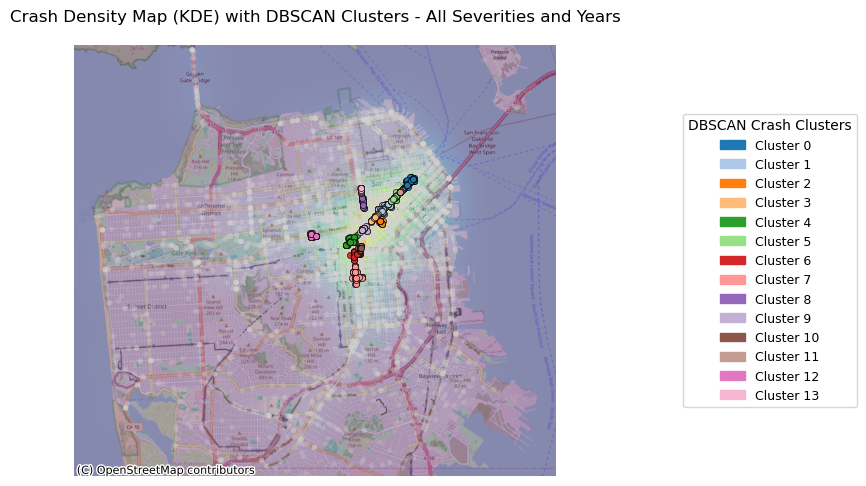

<Figure size 640x480 with 0 Axes>

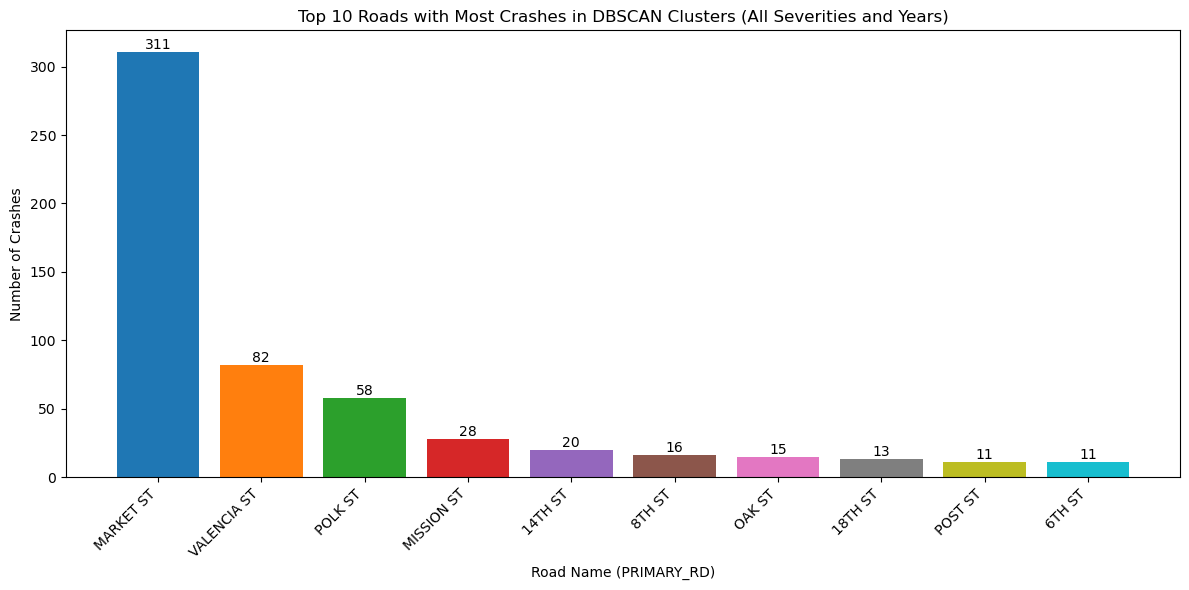

<Figure size 640x480 with 0 Axes>

In [18]:
from tools.KDE import plot_crash_clusters, plot_top_roads_bar

crashes_clustered = plot_crash_clusters(crashes_clean, severity=None, year=None, eps_meters=100, min_samples=25,
                        title_suffix="All Severities and Years")
plot_top_roads_bar(crashes_clustered, top_n=10, severity=None, year=None, title_suffix="All Severities and Years")

The figure above illustrates all bicycle crashes available in the TIMS data set that occured between 2014 and 2024. The first map shows that the highest density of crashes has occured in the downtown area of SF and the following bar graph indicates that there have been many crashes specifically on Market Street, which is corroborated by the map.

Now, lets break down these crashes by severity. Where do the most severe crashes occur? Is there another trend we can find?

/home/jovyan/project/final-group07/tools/KDE.py:103: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_noise.plot(ax=ax, color='lightgrey', markersize=15, alpha=0.25, edgecolor='none')


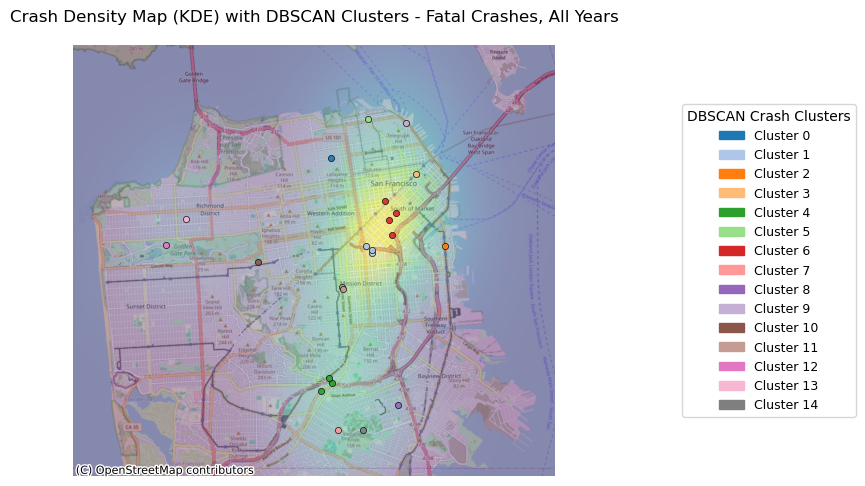

<Figure size 640x480 with 0 Axes>

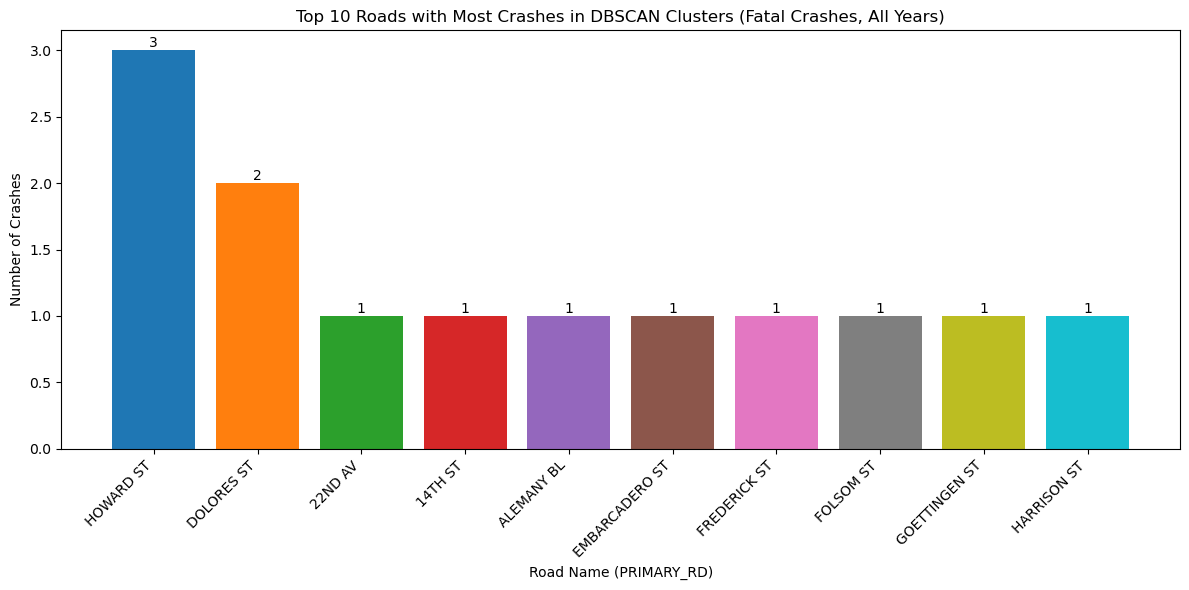

<Figure size 640x480 with 0 Axes>

In [19]:
fatal_crashes_clustered = plot_crash_clusters(crashes_clean, severity=1, year=None, eps_meters=500, min_samples=1,
                        title_suffix="Fatal Crashes, All Years")
plot_top_roads_bar(fatal_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Fatal Crashes, All Years")

Because there are so few fatal crashes, the minimum number of clusters for the analysis was set to 1 in order to visualize where the fatal crashes occured.

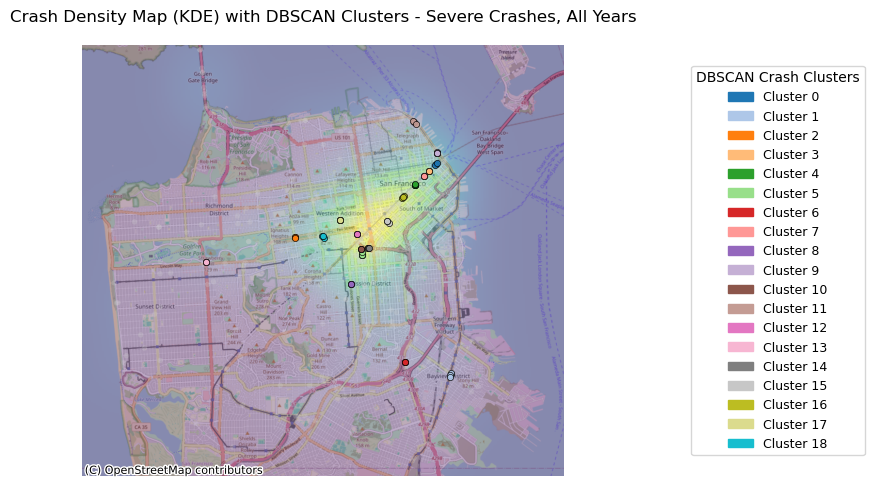

<Figure size 640x480 with 0 Axes>

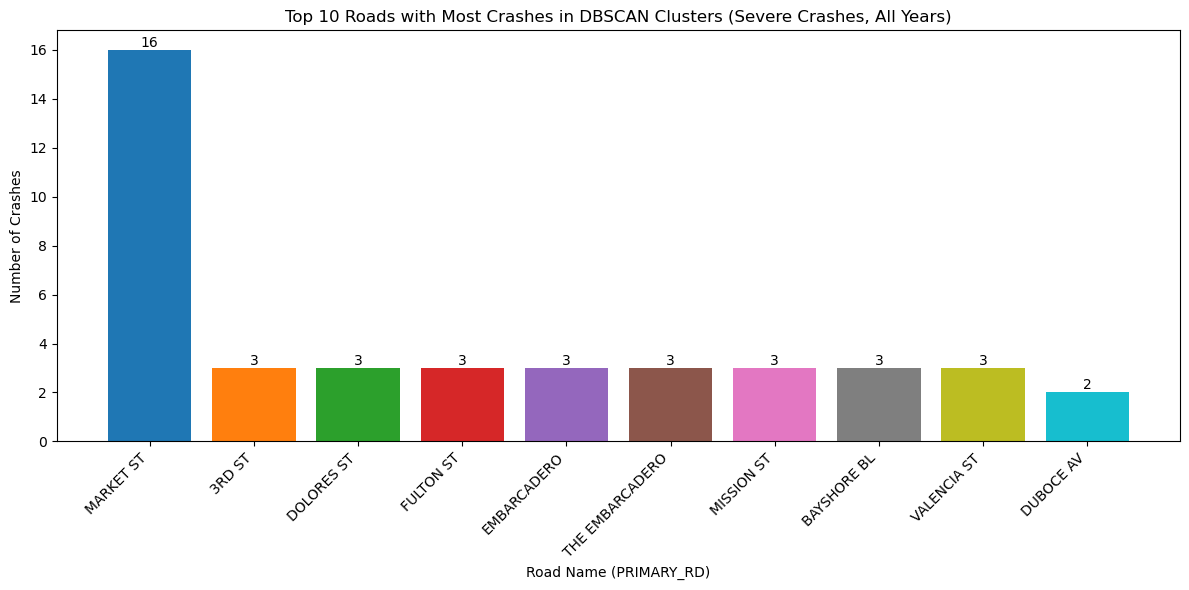

<Figure size 640x480 with 0 Axes>

In [20]:
severe_crashes_clustered = plot_crash_clusters(crashes_clean, severity=2, year=None, eps_meters=75, min_samples=3,
                        title_suffix="Severe Crashes, All Years")
plot_top_roads_bar(severe_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Severe Crashes, All Years")

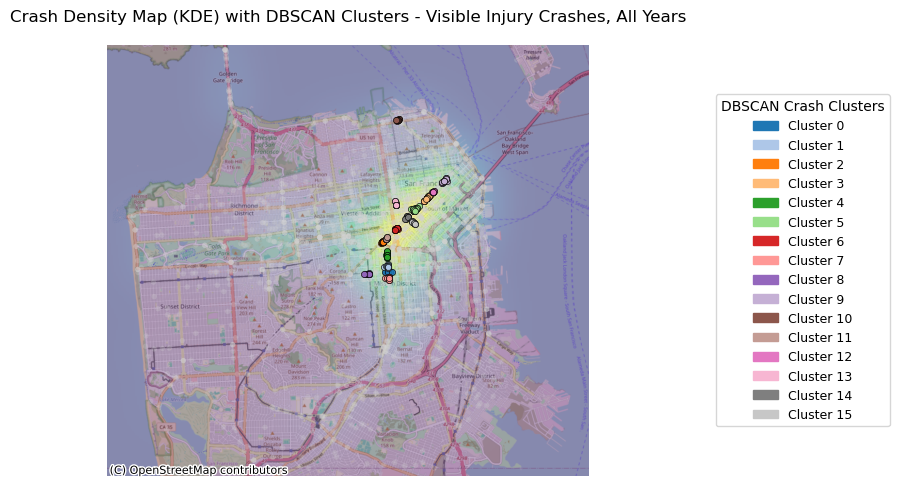

<Figure size 640x480 with 0 Axes>

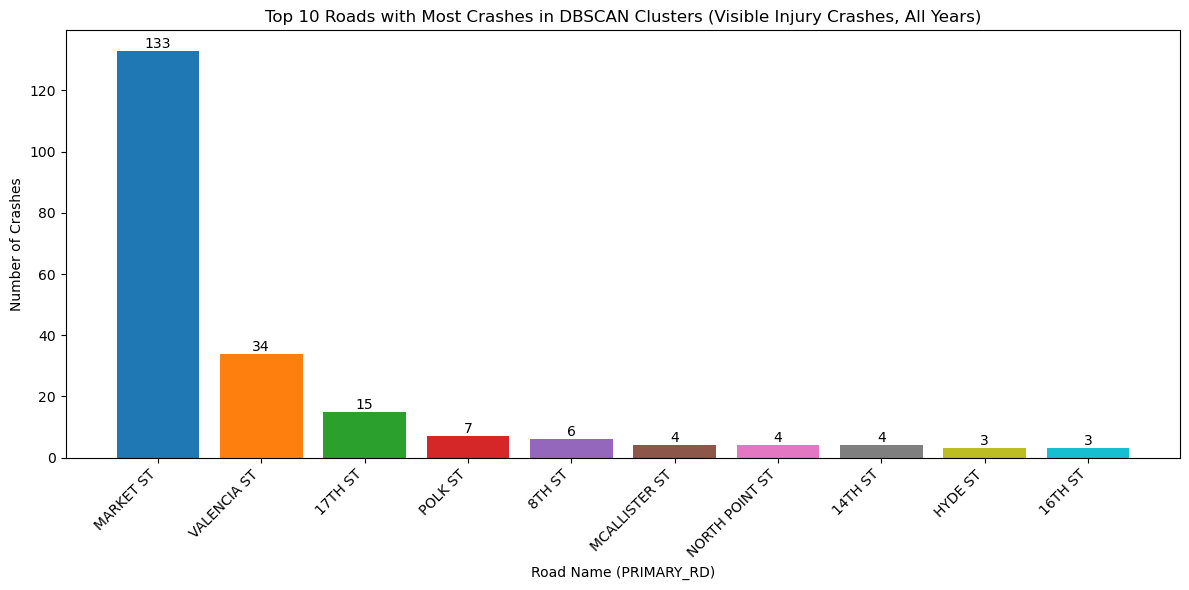

<Figure size 640x480 with 0 Axes>

In [21]:
injury_crashes_clustered = plot_crash_clusters(crashes_clean, severity=3, year=None, eps_meters=75, min_samples=10,
                        title_suffix="Visible Injury Crashes, All Years")
plot_top_roads_bar(injury_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Visible Injury Crashes, All Years")

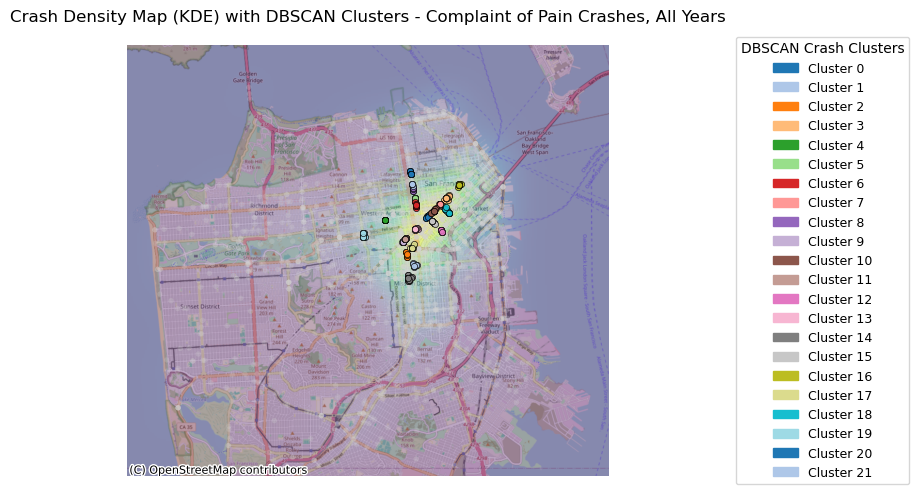

<Figure size 640x480 with 0 Axes>

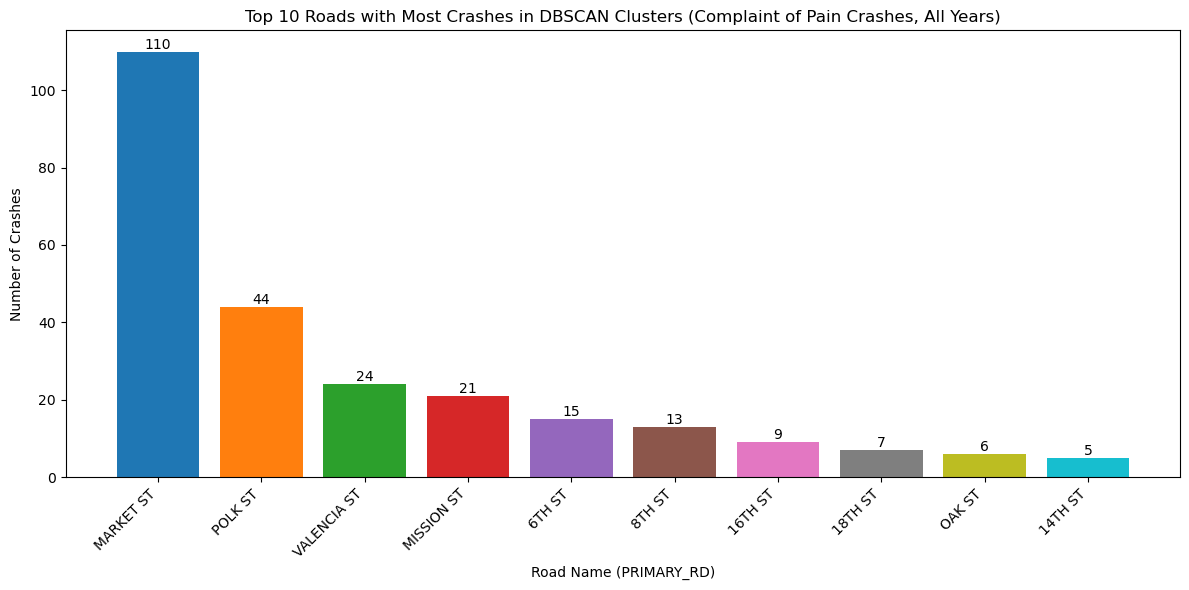

<Figure size 640x480 with 0 Axes>

In [22]:
cop_crashes_clustered = plot_crash_clusters(crashes_clean, severity=4, year=None, eps_meters=75, min_samples= 10,
                        title_suffix="Complaint of Pain Crashes, All Years")
plot_top_roads_bar(cop_crashes_clustered, top_n=10, severity=None, year=None, title_suffix="Complaint of Pain Crashes, All Years")

## Street Trends
The above graphs confirm a startling number of crashes densly clustered on Market Street. However, on January 29, 2020, Market Street was closed to motor vehicles, outside of emergency services and buses. We can see this difference in the two images below. One is from before January 29, 2020, and the other is from after this point.

```{image} KDE_images/MarketStPre.png
:width: 600px
:align: center

This is a picture of Market Street from before the vehicle ban. As shown in the photo, we see vehicles sharing space with bicyclists. These interactions increase the probablility of a crash.

```{image} KDE_images/MarketStPost.png
:width: 600px
:align: center



This is a picture of Market Street from after the vehicle ban. Less interaction between cars and bikes mean less chances of collision.

The change  means that interactions between cars and bikes are now almost zero, except for traffic crossing the street perpendicularly.  When we filter out crashes that occured after that date, we see the following.

In [23]:
# Turn to datetime format
crashes_clean['COLLISION_DATE'] = pd.to_datetime(
    crashes_clean['COLLISION_DATE'],
    errors='coerce'
)

# Filter crashes after 2020-01-29
crashes_recent = crashes_clean[
    crashes_clean['COLLISION_DATE'] > pd.Timestamp('2020-01-29')
]

/home/jovyan/project/final-group07/tools/KDE.py:103: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  gdf_noise.plot(ax=ax, color='lightgrey', markersize=15, alpha=0.25, edgecolor='none')


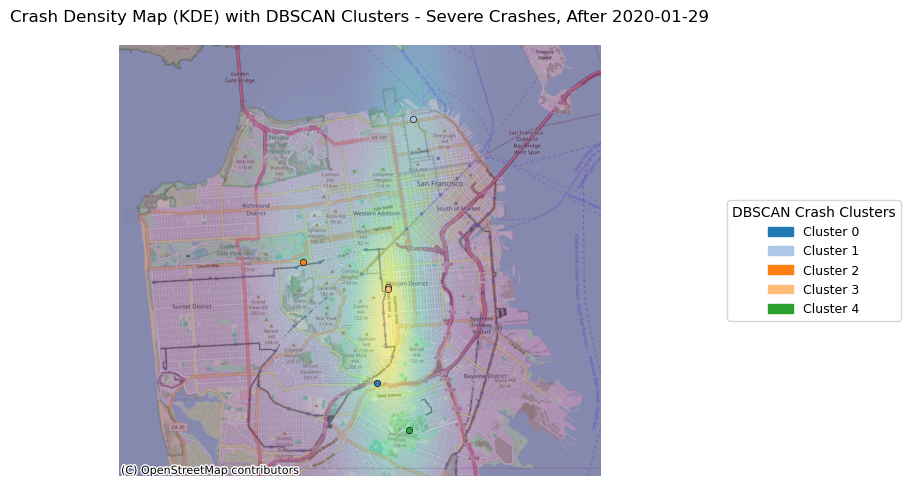

<Figure size 640x480 with 0 Axes>

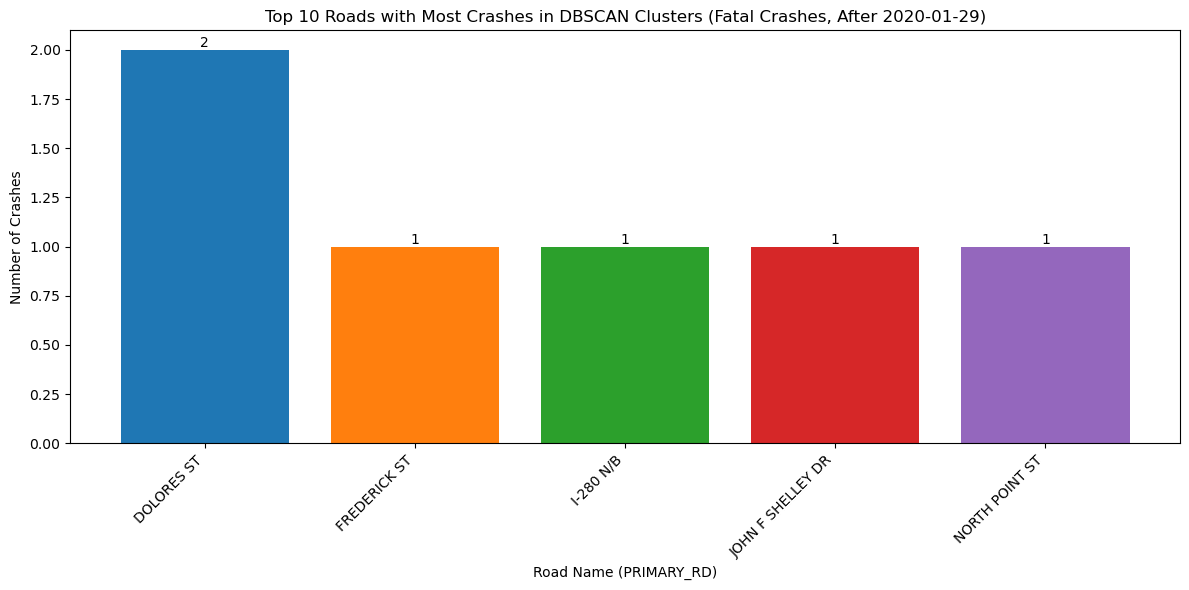

<Figure size 640x480 with 0 Axes>

In [24]:
fatal_recent_clustered = plot_crash_clusters(crashes_recent, severity=1, year=None, eps_meters=500, min_samples= 1,
                        title_suffix="Severe Crashes, After 2020-01-29")
plot_top_roads_bar(fatal_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Fatal Crashes, After 2020-01-29")


Now that the time span has been decreased, there are even fewer crashes and the minimum number of clusters for the analysis was again set to 1 in order to visualize where the fatal crashes occured.

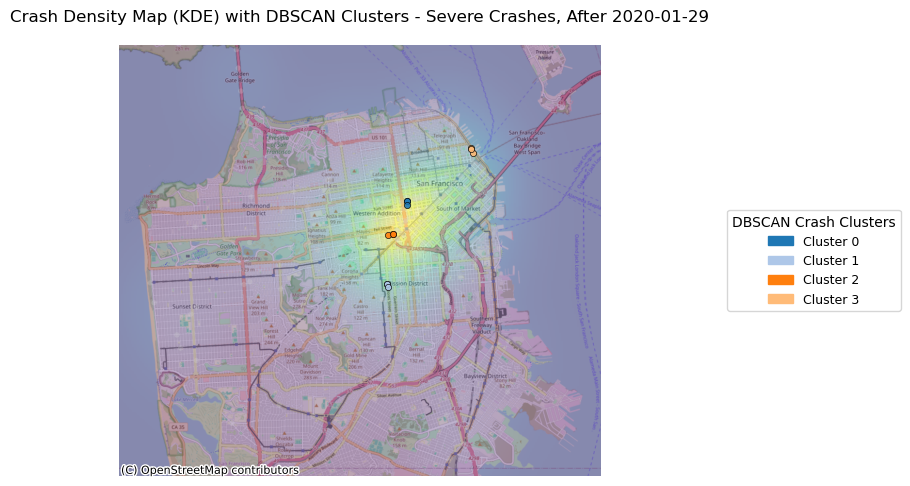

<Figure size 640x480 with 0 Axes>

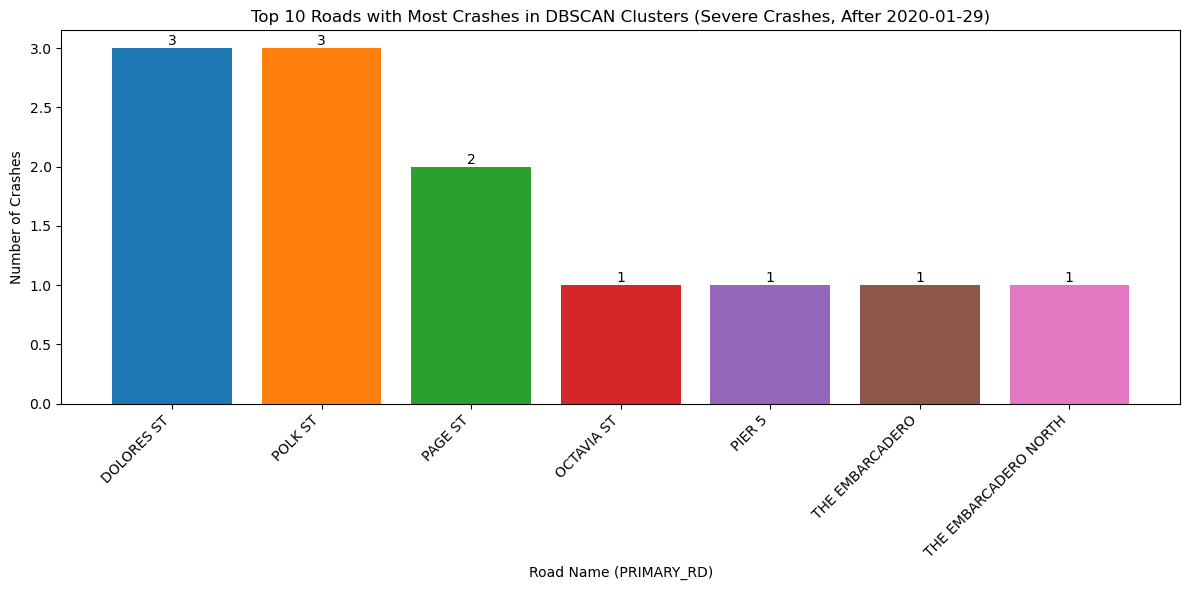

<Figure size 640x480 with 0 Axes>

In [25]:
severe_recent_clustered = plot_crash_clusters(crashes_recent, severity=2, year=None, eps_meters=150, min_samples= 3,
                        title_suffix="Severe Crashes, After 2020-01-29")
plot_top_roads_bar(severe_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Severe Crashes, After 2020-01-29")


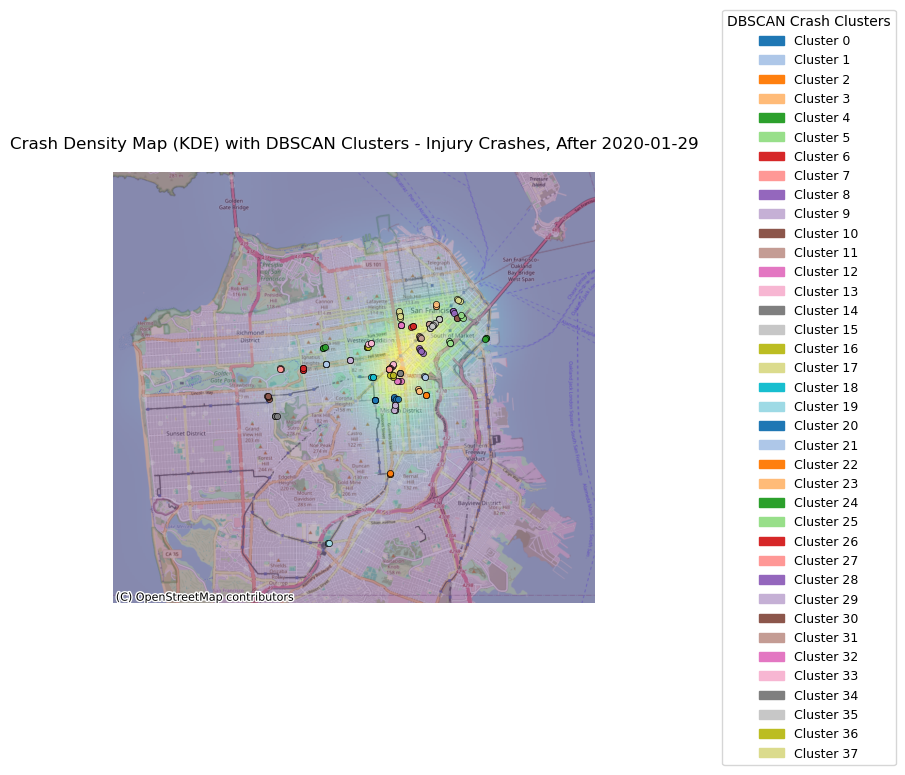

<Figure size 640x480 with 0 Axes>

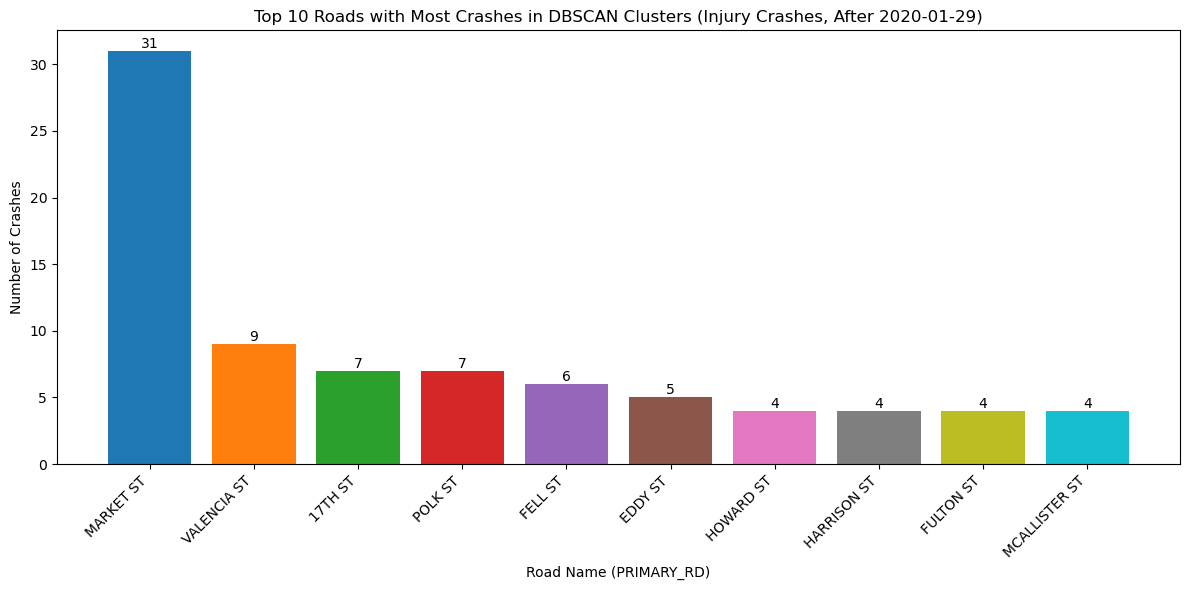

<Figure size 640x480 with 0 Axes>

In [26]:
injury_recent_clustered = plot_crash_clusters(crashes_recent, severity=3, year=None, eps_meters=75, min_samples= 3,
                        title_suffix="Injury Crashes, After 2020-01-29")
plot_top_roads_bar(injury_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Injury Crashes, After 2020-01-29")


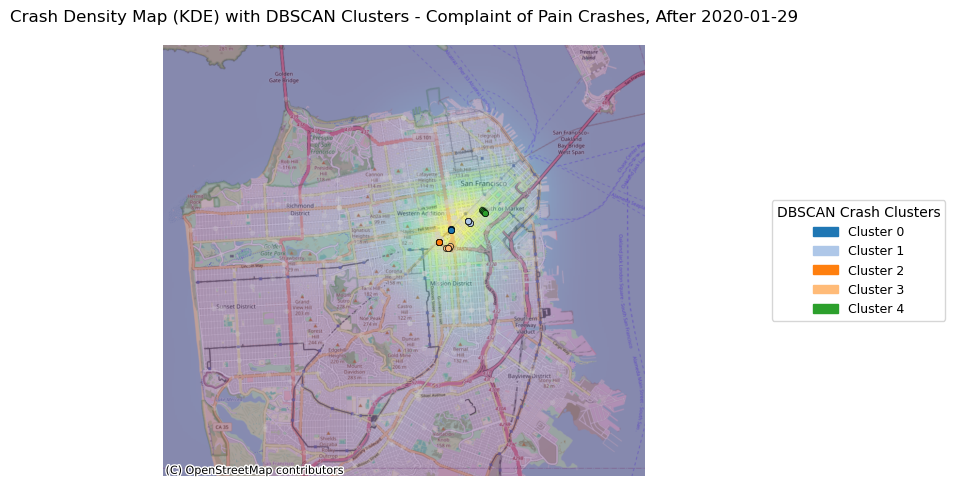

<Figure size 640x480 with 0 Axes>

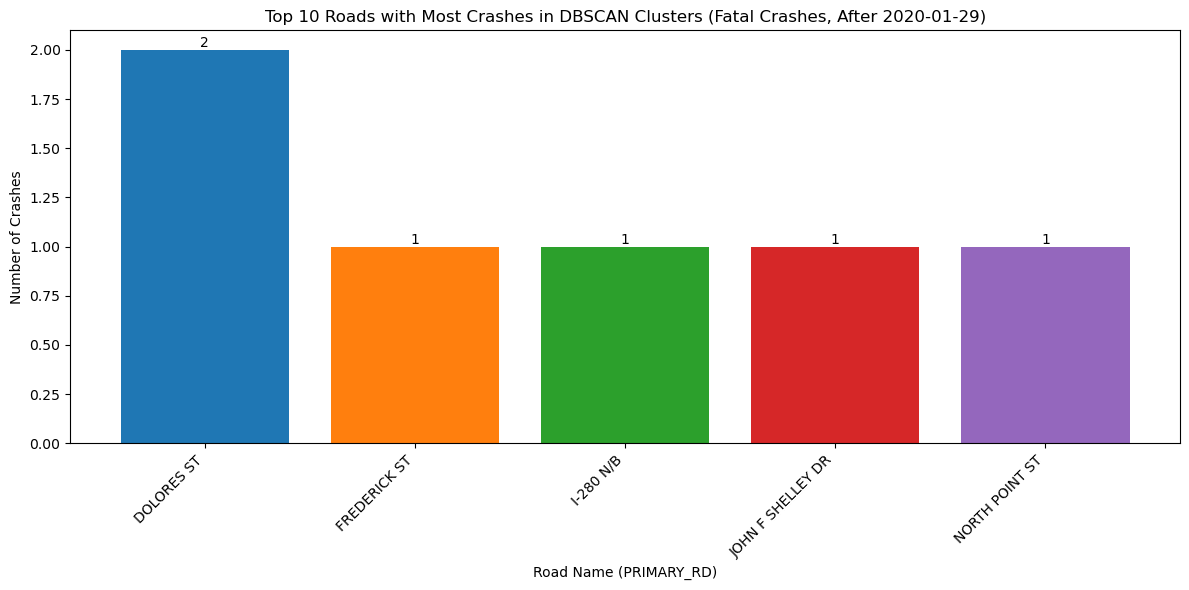

<Figure size 640x480 with 0 Axes>

In [27]:
cop_recent_clustered = plot_crash_clusters(crashes_recent, severity=4, year=None, eps_meters=75, min_samples= 5,
                        title_suffix="Complaint of Pain Crashes, After 2020-01-29")
plot_top_roads_bar(fatal_recent_clustered, top_n=10, severity=None, year=None, title_suffix="Fatal Crashes, After 2020-01-29")


With the change in vehicle allowance on Market Street, it is not surprising that Market Street no longer consistently comes up as a road with an exorbinant amount of crashes. Interestingly, it still appears to have many clustered crashes resulting in visible injuries. However, more consistently, we see roads such as Dolores Street, Frederick Street, and Polk Street. Even when looking at the data over all years, we can see that these three streets appear to have more crashes and are consistently flagged.
<br>
This indicates that there may be infrastructure characteristics that influence the propensity of bicycle crashes on these roads. 

```{image} KDE_images/DoloresSt.png
:width: 600px
:align: center

The above image shows Dolores Street, which does not have bike lanes or any protective considerations for those who may use different modes of travel such as bicycles, scooters, or skateboards. Dolores Street shows high levels of bicyclist fatalities and severe injuries since 2020. This trend may justify the need for greater bicycle safety considerations such as bike lanes.

```{image} KDE_images/FrederickSt.png
:width: 600px
:align: center

Similar to Dolores Street, Frederick Street also does not have bike lanes. Adding these protections and possibly other safety measures such as speed calming measures, more robust infrastructure, or greater signage could help decrease instances of bike collisions.

```{image} KDE_images/PolkSt.png
:width: 600px
:align: center

Polk Street has better bicycle infrastructure; however, it was inconsistent. Some of the bike lane has vertical infrastructure, while other places do not. Further, there are many access points along Polk, such as perpendicular streets and driveways. These are generally unsafe conditions as they create multiple possible interaction points where crashes may occur. Special design considerations should be made that could protect cyclists. Making this street a slow street could be the best way to ensure that any collision that does happen is of the lowest severity.

Photo Credit: Google Maps

# Bike Crash Severity Modelling for San Francisco
## Introduction
In this section we develop models guided by insights from the exploratory data analysis. Our goal is to identify the factors that most strongly predict cyclist injury severity in San Francisco. This differs from studies such as Scarano et al. (2023), which use national datasets and more advanced modeling frameworks; our work applies similar count and severity models to San Francisco’s TIMS bicycle crash data. This is useful because a city-level analysis captures local patterns and street conditions that broader national studies cannot reflect. Although TIMS data are pre-processed and standardized, additional cleaning and filtering were required to obtain a consistent set of San Francisco bicycle crashes suitable for modeling.

## Crash Severity Categories
The data considers four crash severities. The outcome of this kind of statistical modelling is highly dependent on the proportion of data available for each crash severity. In our dataset, the distribution of crash severities is as follows: Fatal (0.5%), Severe Injury (9.5%), Other Visible Injury (44.4%), and Complaint of Pain (45.7%). Given the low proportion of fatal crashes, we combine Fatal and Severe Injury into a single category called "Severe Injury" and combined the other categories into "Other Injury". This results in two categories: Killed or Severely Injured (10%) and Other Injury (90%).

In [14]:
# Display crash severity summary table
import pandas as pd

severity_table = pd.read_csv("figures/crash_severity_summary.csv")
display(
    severity_table.style.hide(axis="index").format({
        "Number of events": "{:,}",
        "Percent of total": "{:.1f}%"
    })
)


In [16]:
# Display KSI crash severity summary table
ksi_table = pd.read_csv("figures/KSI_crash_severity_summary.csv")
display(
    ksi_table.style.hide(axis="index").format({
        "Number of events": "{:,}",
        "Percent of total": "{:.1f}%"
    })
)


## Crash Severity Models
Three classification models: 1) multinomial logit model, 2) random forest, and 3) XGBoost, were used to predict the severity of cyclist injuries in crashes. Reference was made to the research by {cite}`Scarano2023`. The models estimate the probability of Killed or Severely Injured (KSI) or Other injury based on various predictor variables such as road conditions, weather, time of day, cyclist demographics, etc. To determine which parameters to use in the models, we looked at the different variables and removed variables which are nearly constant (low variance). 

Since the number of observations in the "Killed and Severely Injured (KSI)" category is very low compared to the "Other injury" category, for each of the models, we applied some form of class balancing such that the loss allocation across the different categories was approximately equal. The balancing scheme was chosen in a way that maximized the precision (PR) AUC value of each model.

Additionally, in order to determine the best model, we compared their performance using metrics such as accuracy, precision, recall, and F1-score. The model with the highest performance metrics was selected as the best model for predicting severity in San Francisco bike crashes.

### Multinomial Logit Model
We trained a class-balanced logistic regression using an 80-20 test-train split. The random seed of the split was fixed to ensure reproducibility.

### Random Forest Model
We trained a class-balanced random forest model using the same 80-20 test-train split and random seed as the logistic regression model. We tried a small set of hyperparameter configurations (varying tree countand depth) and found that PR AUC plateaued with negligible gains. For this reason, we kept a simple, class-balanced RF with fixed hyperparameters.

### XGBoost Model
We fit an XGBoost classifier with class imbalance handled using scale_pos_weight, using the same 80/20 stratified split and random seed. A quick trial of different tree counts, depths, and learning rates showed PR AUC changes were negligible, so we kept a simple, class-balanced XGBoost configuration with fixed hyperparameters. Additionally, we found that a scale_pos_weight of 0.5 times the weight that balances the classes maximized PR AUC.

In [ ]:
# Displaying model summary
import pandas as pd

summary = pd.read_csv("figures/model_summary.csv")

# Keep numeric cols numeric; fill blanks only in the text column
num_cols = ["ROC AUC", "PR AUC", "Precision", "Recall", "F1-score"]
summary[num_cols] = summary[num_cols].apply(pd.to_numeric, errors="coerce")
summary["Model"] = summary["Model"].fillna("")

display(
    summary.style.hide(axis="index").format(
        formatter={c: "{:.3f}" for c in num_cols},
        na_rep=""  # show blanks instead of NaN
    )
)


### Selecting the Best Crash Severity Model
Based on the performance metrics, we selected the Random Forest model as the best model since it has the best overall balance. This model has the top ROC AUC (0.620) and the highest KSI F1 and KSI recall values among the three models trained. XGBoost nas a slightly better PR AUC value than Random Forest (0.168 vs 0.156) however, it has much a lower KSI recall and F1 score. It also has the best model for predicting crash severity in San Francisco bike crashes. 

The Random Forest model was be used for further analysis and interpretation using SHAP (SHapley Additive exPlanations) to determine the most influential factors in the crash severity model {cite}`shap`.

#### SHAP Analysis of the Random Forest Model
SHAP values were calculated for the Random Forest model to interpret the influence of each feature on the model's predictions. The SHAP summary plot shows the impact of each feature on the model output, with features ranked by their importance. The color of the points indicates the value of the feature (red for high values such as 1 for categorical features, blue for low values such as 0 for categorical features), and the position on the x-axis indicates the effect on the prediction (positive or negative impact on KSI probability). Since the primary and secondary road featires were dominating the SHAP plots, we separated them from the other features to better visualize the impact of the other features. For both the road and non-road features SHAP analysis, we created two plots, the SHAP beeswarm plot and the SHAP bar plot. The different categories were interpreted with reference to the TIMS SWITRS data codebook {cite}`tims_switrs`.

##### SHAP Analysis for Road Features
From the SHAP analysis of features relating to the road on which the crash occured i.e., "Primary_RD" and "Secondary_RD", we can see from the SHAP beeswarm and bar plots that some roads have a higher likelihood of KSI crashes. For example, crashes on Bayshore Boulevard, Balboa Street and Hill Street have a higher likelihood of being KSI crashes. On the other hand, crashs on Townsend Street, 18th Street adn California Street have a lower likelihood of being KSI crashes.

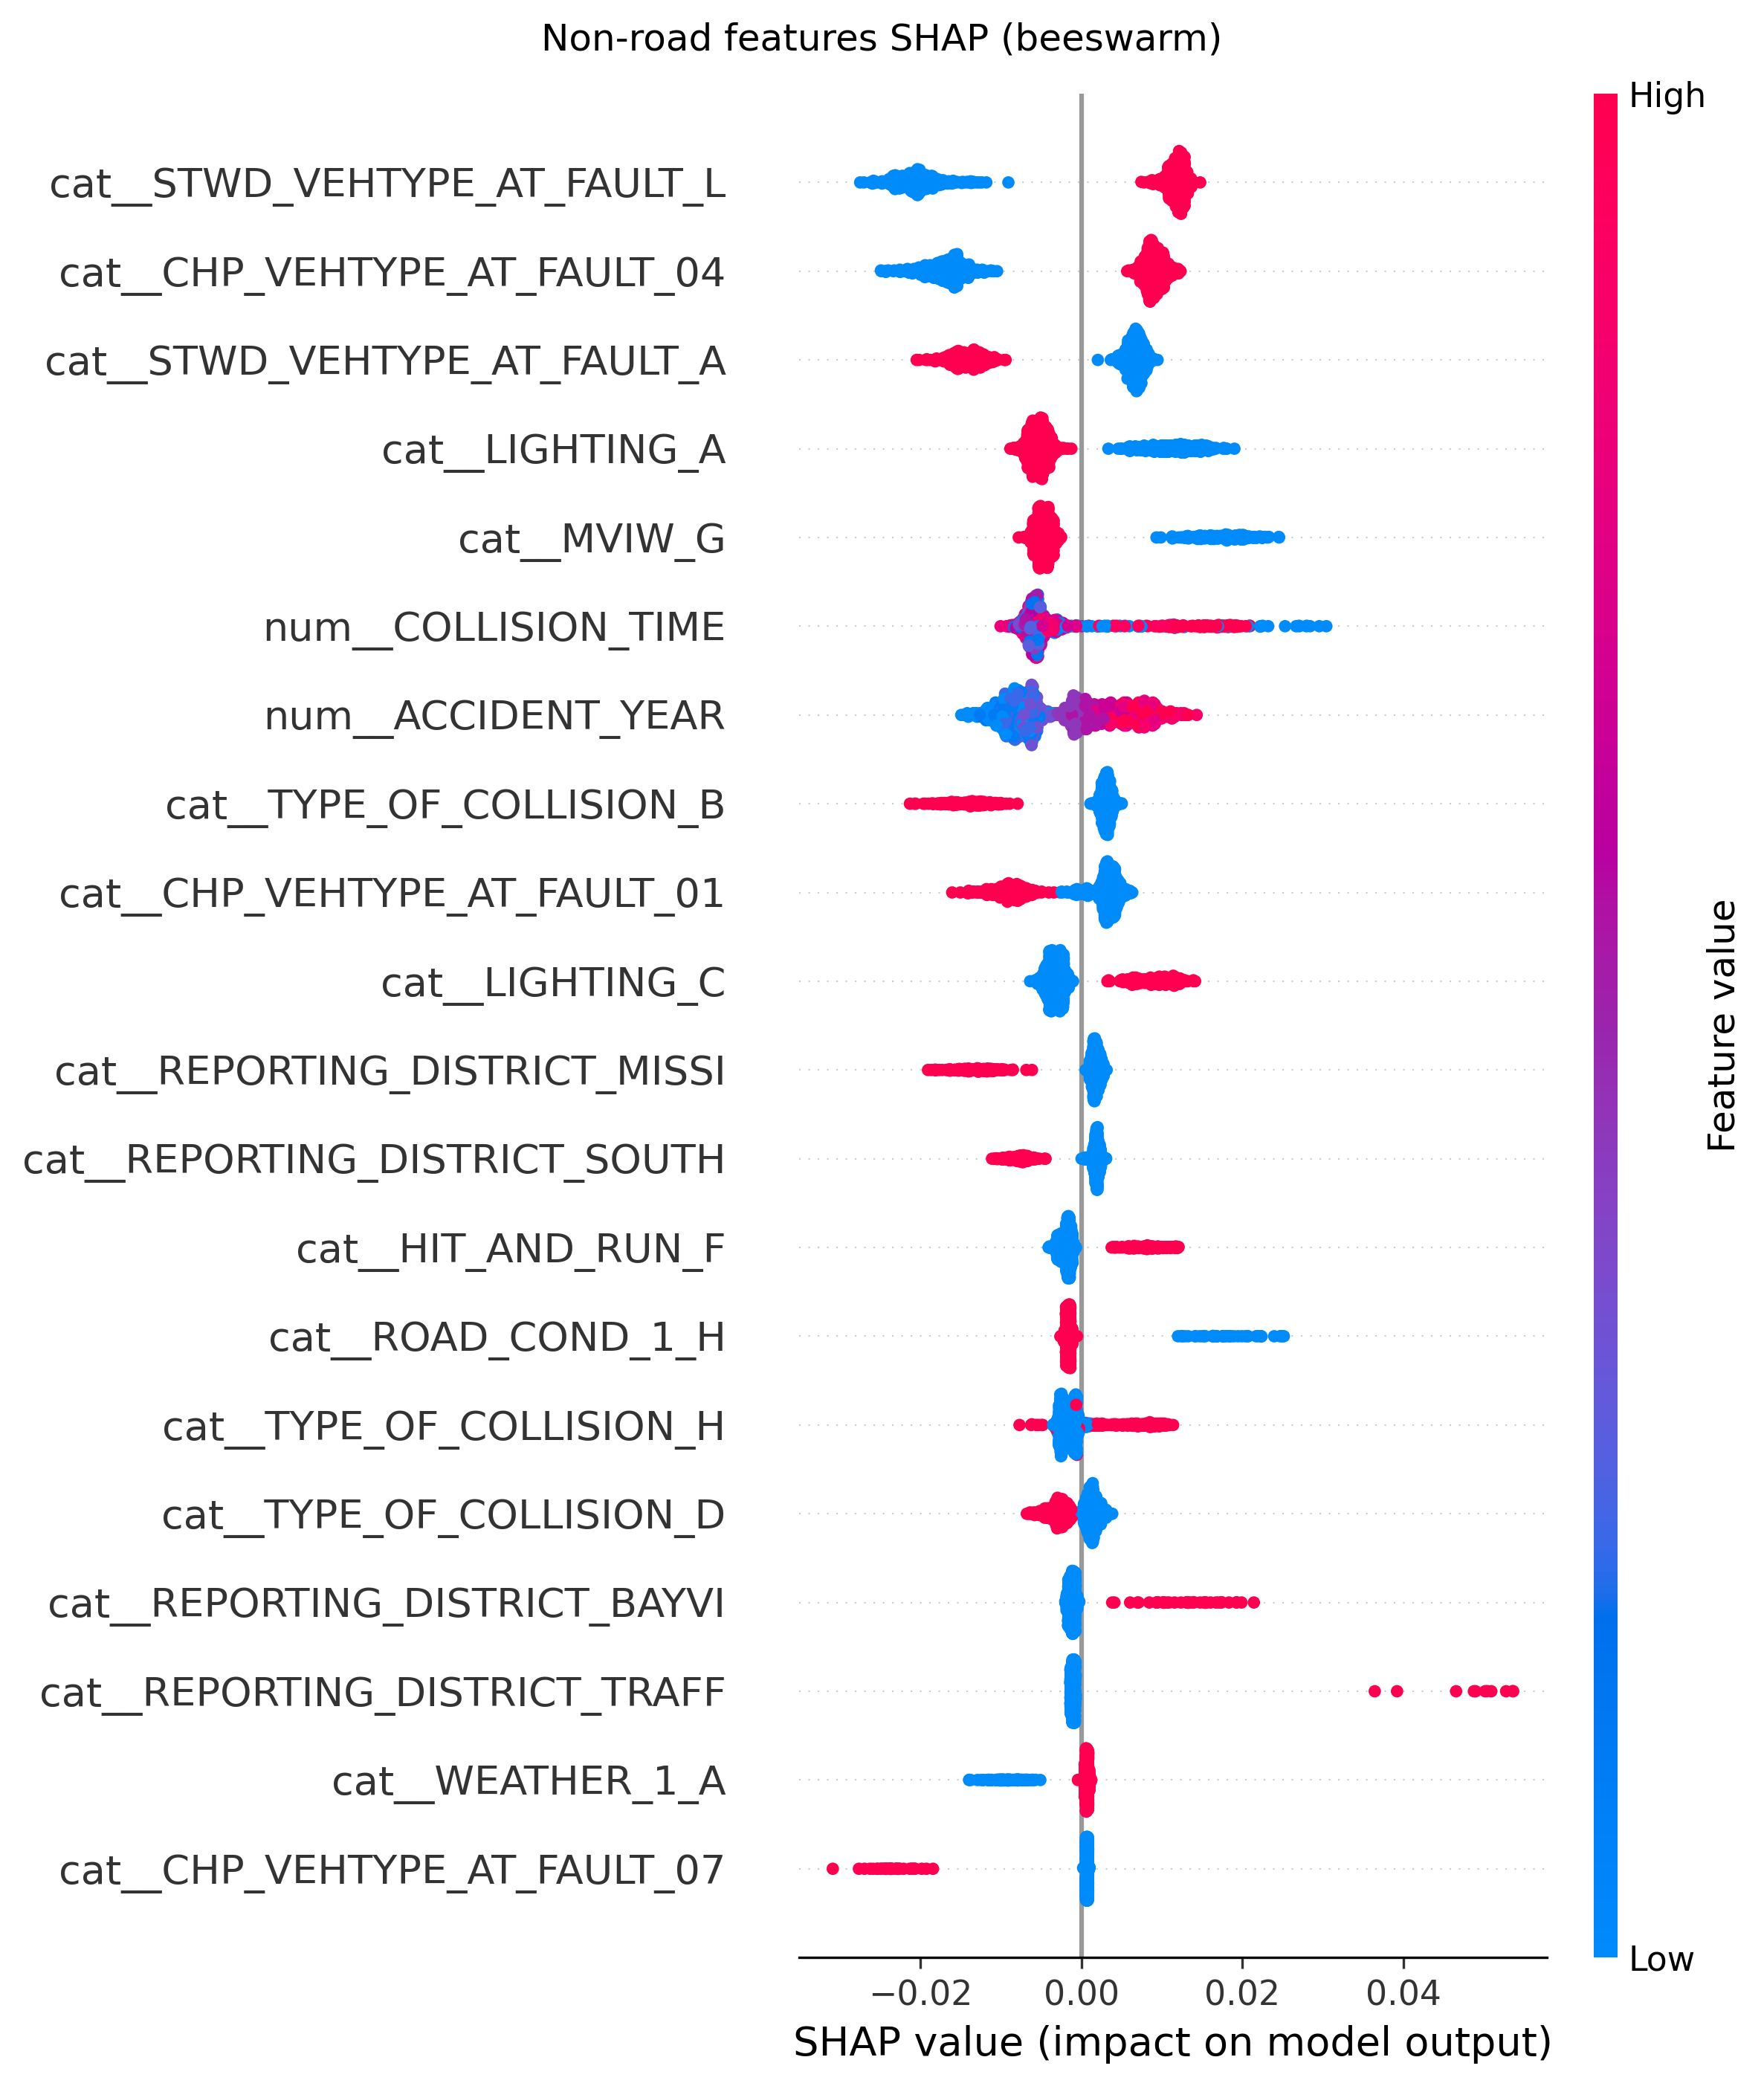

In [6]:
Image(filename = "figures/nonroad_shap_beeswarm.png")

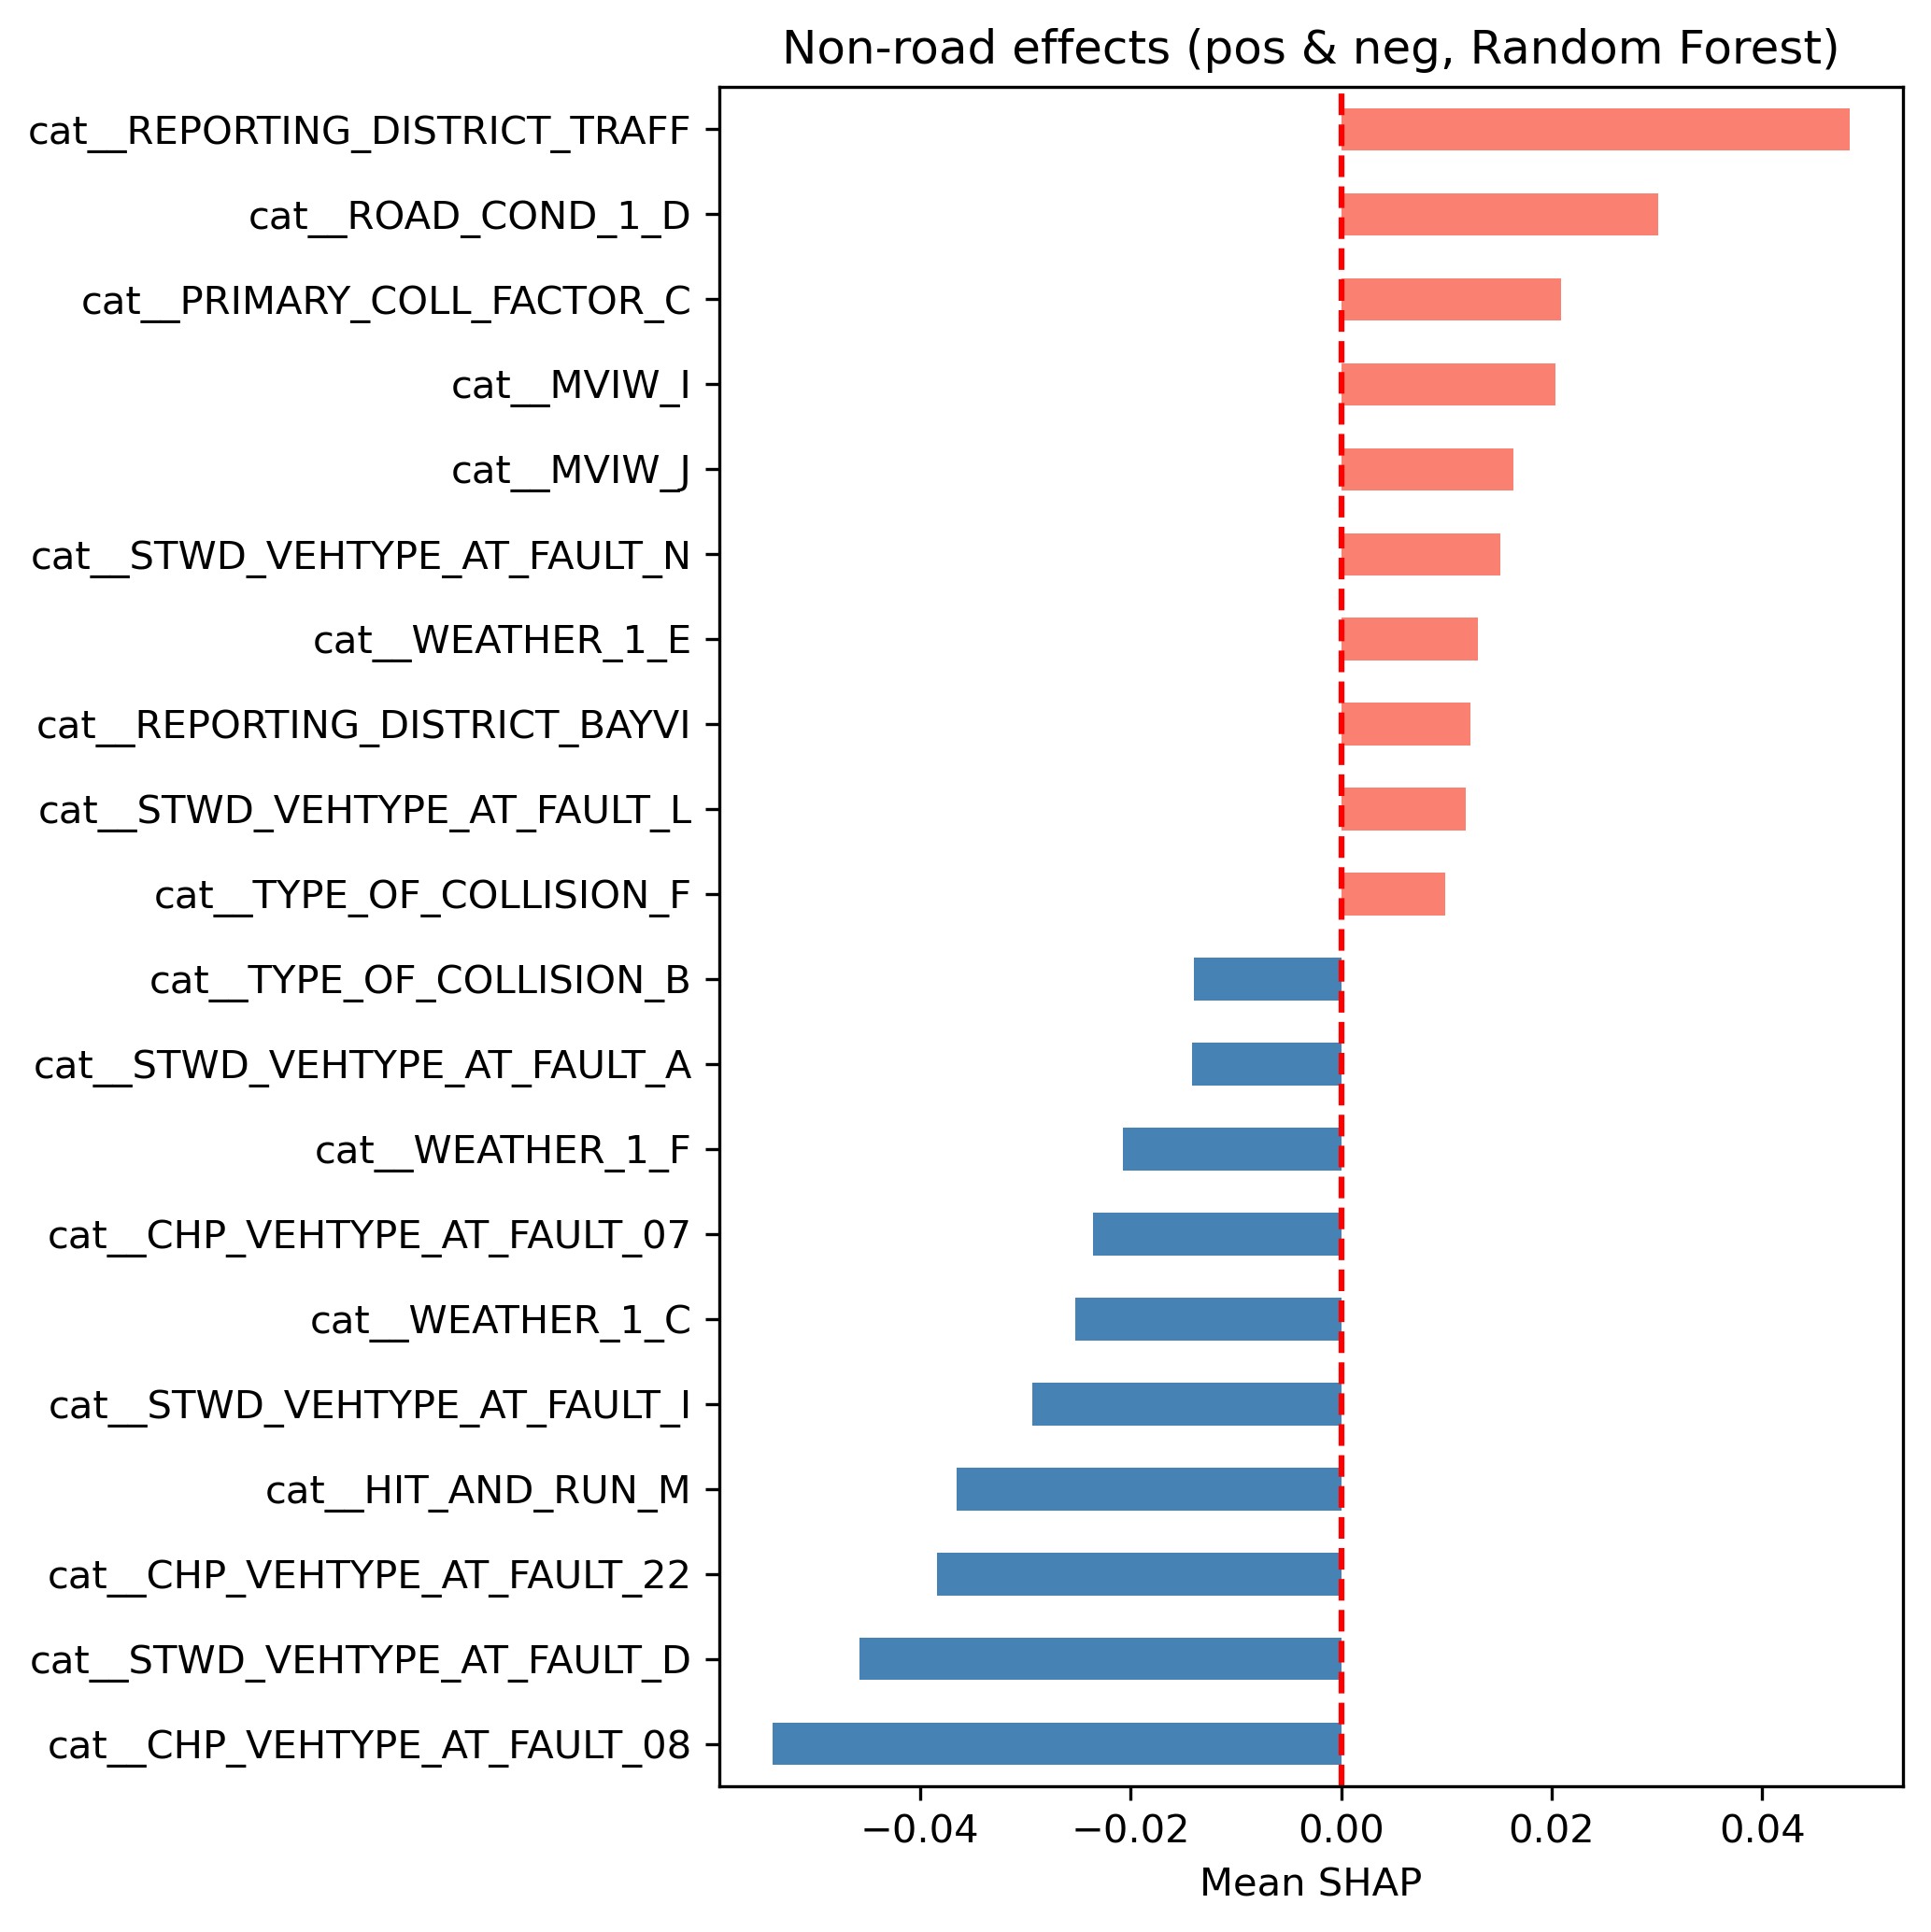

In [7]:
Image(filename = "figures/nonroad_effects_SHAP_bar.png")

##### SHAP Analysis for Non-Road Features
From the SHAP analysis of features not relating to the road on which the crash occured such as vehicle type at fault, lighting, type of collision, reporting district, collision type, accident year and weather, we can see from the SHAP beeswarm and bar plots that some categories or values have a higher likelihood of KSI crashes. For example, crashes from the traffic reporting district, those on road_condition_1_ D (construction or repair zone), those involving primary_collision_factor_C (other than driver), type_of_collision_F (overturned) and stwd_vehtype_at_fault_L (bicycle) have a higher likelihood of being KSI crashes. On the other hand, crashes where the vehicle type at fault is not the bicycle (is a bus, minivan, truck or sports utility vehicle), the weather is rainy (weather_1_C) or type of collision is a sideswipe(type_of_collision_B) have have a lower likelihood of being KSI crashes.

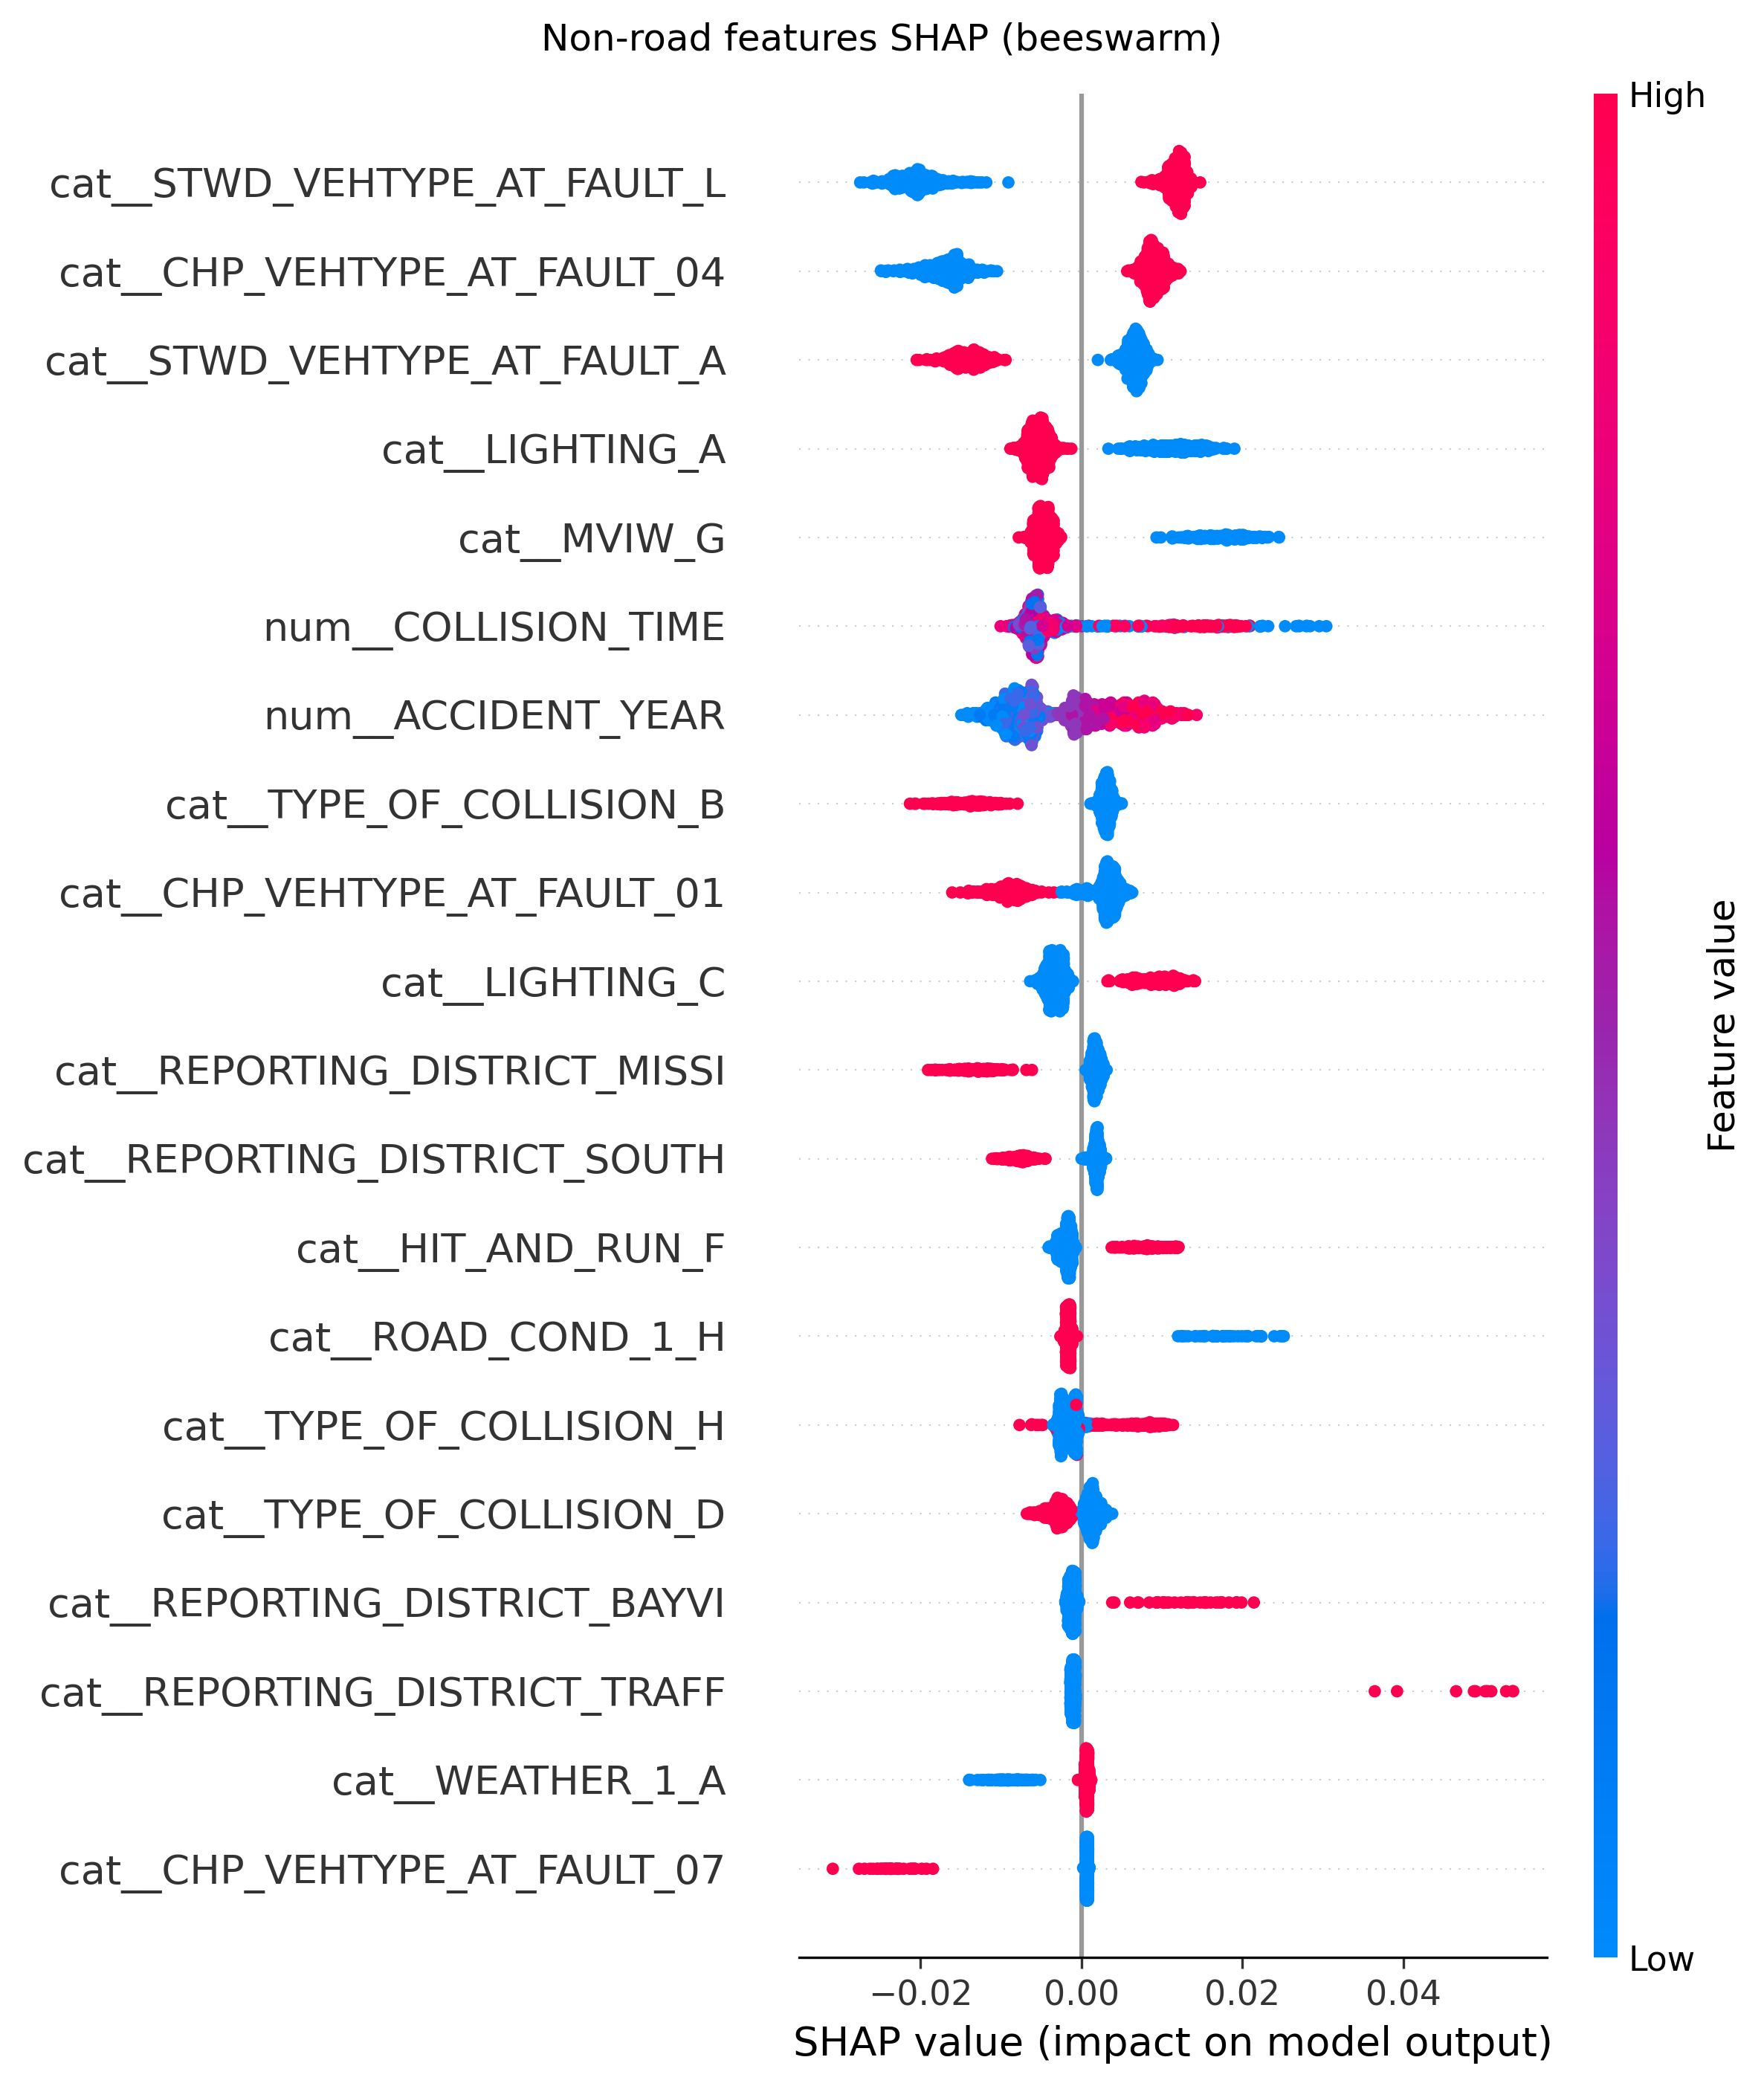

In [9]:
Image(filename = "figures/nonroad_shap_beeswarm.png")

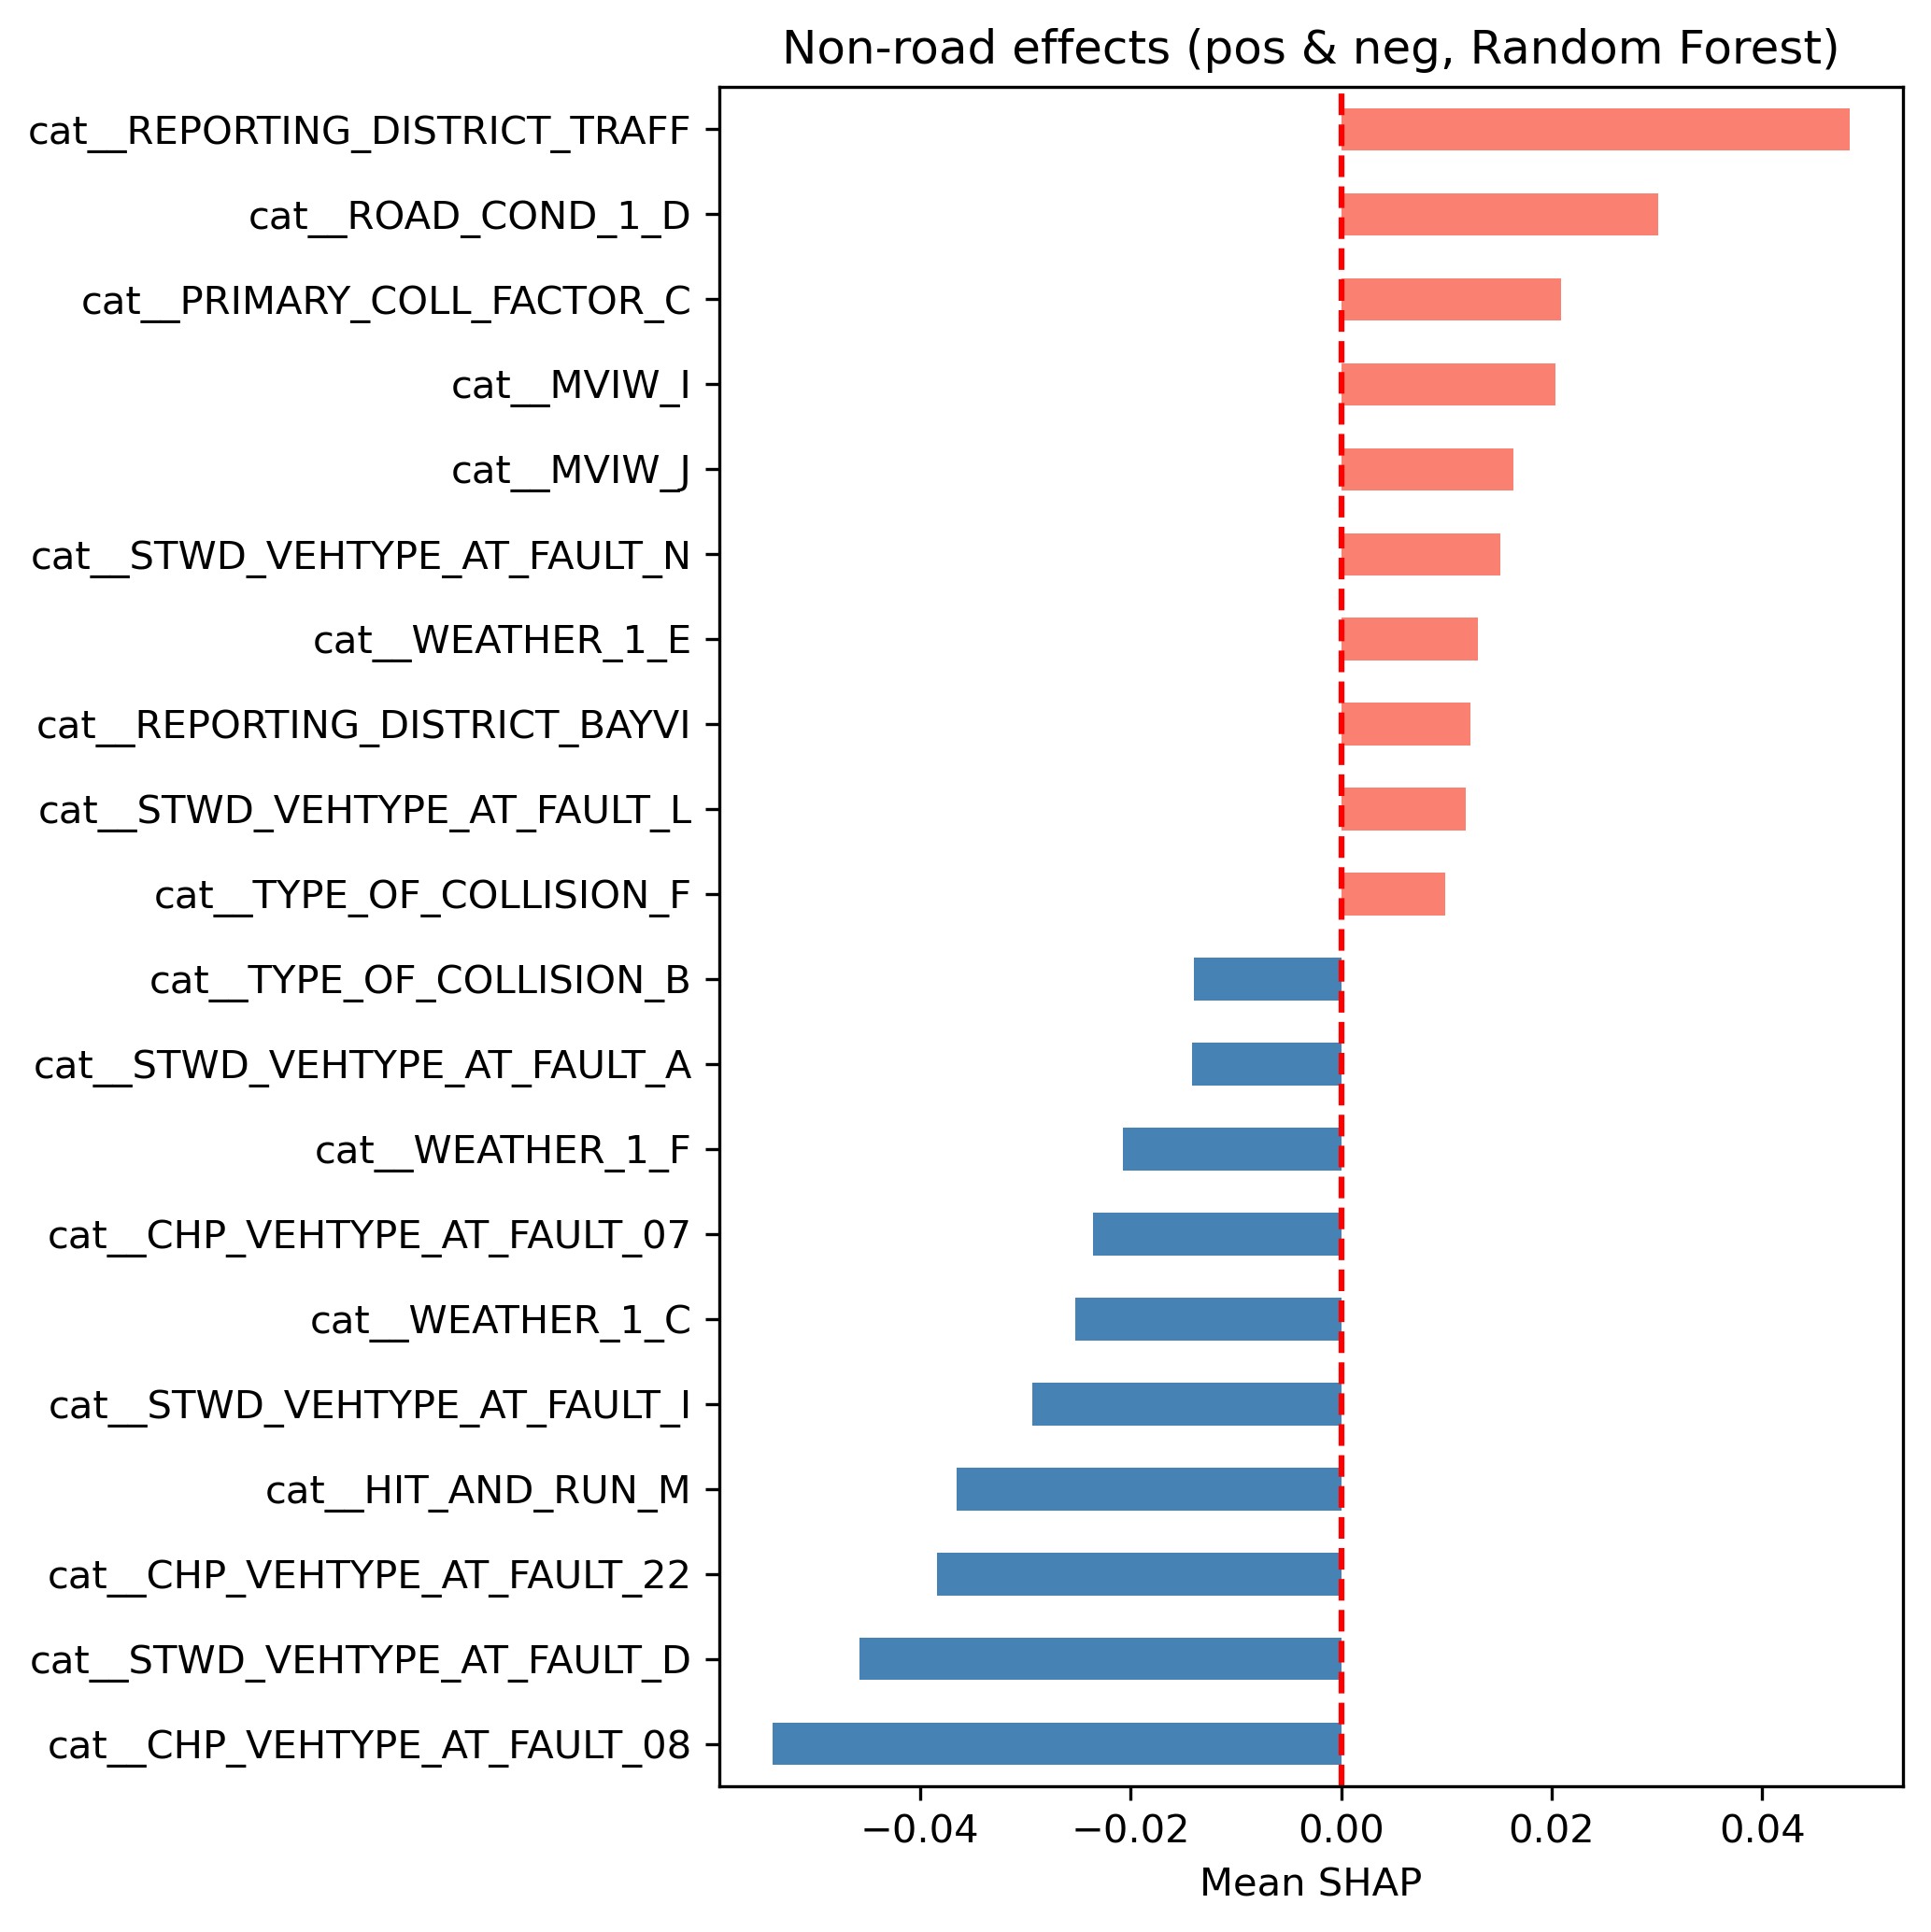

In [10]:
Image(filename = "figures/nonroad_effects_SHAP_bar.png")

## Major Observations from the Modelling
The Random Forest model outperformed the other two models in predicting crash severity in San Francisco bike crashes, especially in identifying KSI (Killed or Severely Injured) crashes. The SHAP analysis revealed that certain roads and crash characteristics significantly influence the likelihood of severe injuries. 

As was observed in the clustering analysis, specific roads such as Dolores Street and Bayshore Boulevard are associated with higher severity crashes. These associations were confirmed by the SHAP beeswarm plot for road features, which showed that crashes on these roads have a higher likelihood of being KSI crashes (positive SHAP value). 

Additionally, non-road features such as vehicle type at fault, lighting conditions, and type of collision also play a significant role in determining crash severity. Specifically, it was found that crashes in construction or repair zones, those involving a primary collision factor that is not the driver, crashes involving overturning and crashes where the cyclist was at fault have a higher likelihood of being KSI crashes.

These insights, together with what was observed in the EDA and Clustering Analyses, can inform targeted interventions to further improve cyclist safety in San Francisco.

## Author Contributions

- Reily Fairchild: Did the initial set up of the notebook, setting up the environment, makefile, tools, and myst files. Collaborated with Aditya on EDA, and then individually set that section in a strong narrative framing and consistent graph visuals.
- Jordan Collins: Did the spatial analysis, Google Maps assessment, and review of files near the end of the project. Made sure to include tests, modularize functions, and create a clean notebook.
- Aditya Mangalampalli: Worked on the packaging of our utility package `tools` by adding unit tests, helped contribute to the `Makefile`, set up the `mystmd` and it's respective Github Pages hosting, added appropriate licensing, populated the `README` with important information about the project, and collaborated with Reily on EDA.
- Atiila Joselyn Birah Kharobo: Did the modelling section of the project which included data cleaning, model selection, training and evaluation. Additionally, did SHAP analysis to interpret the model results and included visualizations and tests to support the findings.
